In [93]:
# import torch geometric before qubic because sympy will complain

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
import torch_geometric.nn as gnn
from torch_geometric.data import Data, DataLoader

In [2]:
from pylab import *
import gc
import pickle5 as pickle
import inspect

import healpy as hp
import numpy as np

from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import qubic
import qubic.lib.QskySim as qss
from qubic import SpectroImLib as si
from qubic import camb_interface as qc
from pysm3 import models
import pysm3

[proton:351848] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [3]:
from tqdm import tqdm
from pygsp import graphs

import torch.distributed as dist
import torch.multiprocessing as mp
from itertools import combinations

In [4]:
from pyoperators import MPIDistributionIdentityOperator, HomothetyOperator, DiagonalOperator, IdentityOperator, Rotation2dOperator, Rotation3dOperator, ReshapeOperator,BlockDiagonalOperator, DenseBlockDiagonalOperator, CompositionOperator
from pysimulators import ConvolutionTruncatedExponentialOperator, ProjectionOperator
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, HealpixConvolutionGaussianOperator
from qubic.ripples import ConvolutionRippledGaussianOperator

In [5]:
from pygsp import graphs, filters
from scipy import sparse

In [6]:
%matplotlib inline

In [7]:
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubic.lib.qubicDict()
d.read_from_file(dictfilename)

center = qubic.lib.equ2gal(d['RA_center'], d['DEC_center'])

In [8]:
d['nf_recon'] = 1
d['MultiBand'] = False

d['synthbeam_kmax'] = 1
nf_sub = d['nf_sub']
d['synthbeam_fraction'] = 1

d['use_synthbeam_fits_file'] = False

In [9]:
d['noiseless'] = True
d['photon_noise'] = False

In [10]:
d['npointings'] = 4000

In [11]:
d['nside'] = 128

In [12]:
seed = 42
sky_config = {'cmb': seed, 'dust': 'd0'}
Qubic_sky = qss.Qubic_sky(sky_config, d)
sky_map = Qubic_sky.get_simple_sky_map()

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


In [13]:
p = qubic.lib.get_pointing(d)
s = qubic.lib.QubicScene(d)
q = qubic.lib.QubicInstrument(d)

In [14]:
_, nus_edge, nus, _, _, _ = qubic.lib.compute_freq(d['filter_nu'] / 1e9, d['nf_sub'], d['filter_relative_bandwidth'])

In [15]:
acquisition = qubic.lib.QubicAcquisition(q, p, s, d)

In [16]:
H = acquisition.get_operator()

Info proton: Allocating (3968000,9) elements = 544.921875 MiB in FSRRotation3dMatrix.__init__.


In [17]:
convolution = acquisition.get_convolution_peak_operator()
convolved_maps = convolution(sky_map[0])

In [18]:
cov = acquisition.get_coverage()

Info proton: Allocating (3968000,9) elements = 544.921875 MiB in FSRRotation3dMatrix.__init__.


## Graph structure

In [19]:
def healpix_weightmatrix(nside=16, nest=True, indexes=None, dtype=np.float32):
    """Return an unnormalized weight matrix for a graph using the HEALPIX sampling.

    Parameters
    ----------
    nside : int
        The healpix nside parameter, must be a power of 2, less than 2**30.
    nest : bool, optional
        if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
    indexes : list of int, optional
        List of indexes to use. This allows to build the graph from a part of
        the sphere only. If None, the default, the whole sphere is used.
    dtype : data-type, optional
        The desired data type of the weight matrix.
    """
    if not nest:
        raise NotImplementedError()

    if indexes is None:
        indexes = range(nside**2 * 12)
    npix = len(indexes)  # Number of pixels.
    if npix >= (max(indexes) + 1):
        # If the user input is not consecutive nodes, we need to use a slower
        # method.
        usefast = True
        indexes = range(npix)
    else:
        usefast = False
        indexes = list(indexes)

    # Get the coordinates.
    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    coords = np.asarray(coords, dtype=dtype)
    # Get the 7-8 neighbors.
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
    # if use_4:
    #     print('Use 4')
    #     col_index = []
    #     row_index = []
    #     for el,neighbor in zip(indexes,neighbors.T):
    #         x, y, z = hp.pix2vec(nside, [el], nest=nest)
    #         coords_1 = np.vstack([x, y, z]).transpose()
    #         coords_1 = np.array(coords_1)

    #         x, y, z = hp.pix2vec(nside, neighbor, nest=nest)
    #         coords_2 = np.vstack([x, y, z]).transpose()
    #         coords_2 = np.asarray(coords_2)
    #         ind = np.argsort(np.sum((coords_2-coords_1)**2,axis=1),)[:4]
    #         col_index = col_index + neighbor[ind].tolist()
    #         row_index = row_index +[el]*4
    #     col_index = np.array(col_index)
    #     row_index = np.array(row_index)
    # else:
    # Indices of non-zero values in the adjacency matrix.
    col_index = neighbors.T.reshape((npix * 8))
    row_index = np.repeat(indexes, 8)

    # Remove pixels that are out of our indexes of interest (part of sphere).
    if usefast:
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
    else:
        col_index_set = set(indexes)
        keep = [c in col_index_set for c in col_index]
        inverse_map = [np.nan] * (nside**2 * 12)
        for i, index in enumerate(indexes):
            inverse_map[index] = i
        col_index = [inverse_map[el] for el in col_index[keep]]
        row_index = [inverse_map[el] for el in row_index[keep]]

    # Compute Euclidean distances between neighbors.
    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2

    # Compute similarities / edge weights.
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    # Similarity proposed by Renata & Pascal, ICCV 2017.
    # weights = 1 / distances

    # Build the sparse matrix.
    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)

    # if use_4:
    #     W = (W+W.T)/2

    return W

In [20]:
def healpix_graph(nside=16,
                  nest=True,
                  lap_type='normalized',
                  indexes=None,
                  use_4=False,
                  dtype=np.float32):

    if indexes is None:
        indexes = range(nside**2 * 12)

    npix = hp.nside2npix(nside)  
    pix = range(npix)
    x, y, z = hp.pix2vec(nside, pix, nest=nest)
    coords = np.vstack([x, y, z]).transpose()[indexes]
    if use_4:
        raise NotImplementedError()
        W = build_matrix_4_neighboors(nside, indexes, nest=nest, dtype=dtype)
    else:
        W = healpix_weightmatrix(
            nside=nside, nest=nest, indexes=indexes, dtype=dtype)
    G = graphs.Graph(
        W,
        lap_type=lap_type,
        coords=coords)
    G.signal = np.zeros(len(indexes), dtype=dtype)
    return G

In [21]:
def get_nside_from_graph(G):
    npix = G.N  
    nside = int(np.sqrt(npix / 12))
    return nside

In [22]:
def get_high_coverage_indexes(cov_map, threshold=0.15):
    maxcov = np.max(cov_map)
    unseen = cov_map < maxcov * threshold
    seen_indexes = np.where(~unseen)[0]  
    return seen_indexes

In [23]:
def get_G_masked_by_cov(G, nside, cov_map, threshold=0.15):
    G_partial_list = []
    if len(cov_map.shape) == 1:
        seen_indexes = get_high_coverage_indexes(cov_map, threshold = treshold)
        G_partial = G.subgraph(seen_indexes)
        G_partial.signal = G.signal[seen_indexes]
        G_partial.det_TOD = G.det_TOD
        print(seen_indexes)
        return G_partial
    
    for row in cov_map:
        seen_indexes = get_high_coverage_indexes(row, nside, threshold=threshold)
        print(seen_indexes)
        G_partial = G.subgraph(seen_indexes)
        G_partial.signal = G.signal[seen_indexes]
        G_partial.det_TOD = G.det_TOD
        
        G_partial_list.append(G_partial)
    
    if cov_map.shape[0] == 1:
        return G_partial_list[0]
    
    return G_partial_list

In [24]:
def get_G_masked_by_cov(G, nside, cov_map, treshold = 0.15): #you have to provide one or the second
    seen_indexes = get_high_coverage_indexes(cov_map, threshold = treshold)
    seen_indexes = hp.ring2nest(nside, seen_indexes)
    G_partial = G.subgraph(seen_indexes)
    G_partial.signal = G.signal[seen_indexes]
    G_partial.coords = G.coords[seen_indexes]
    return G_partial

In [25]:
def plot_sky_3d(graph_map, elev=10, azim=0, edges=False, vmin = None, vmax = None):
    signal = graph_map.signal
    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()
    signal = signal.copy()
    
    
    if vmin is None:
        vmin = signal[signal != -1.6375e+30].min()
    if vmax is None:
        vmax = signal.max()

    graph_map.plotting.update(vertex_size=0.6)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111, projection='3d')
    
    graph_map.plot_signal(graph_map.signal, show_edges = False, ax=ax, limits = [vmin, vmax])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [26]:
seen_indexes = get_high_coverage_indexes(cov)
seen_indexes = hp.ring2nest(d['nside'], seen_indexes)

In [27]:
G = healpix_graph(d['nside'], indexes = seen_indexes)

In [28]:
input_map_reord = hp.reorder(convolved_maps[:,0], r2n=True)

G_sky = healpix_graph(nside=d['nside'], nest=True)

G_sky.signal = input_map_reord 

In [29]:
G_sky_partial = G_sky.subgraph(seen_indexes)
G_sky_partial.signal = G_sky.signal[seen_indexes]

In [30]:
G_sky_partial.coords = G_sky.coords[seen_indexes]

## Multifeature Graph Structure

In [31]:
def healpix_weightmatrix_multifeature(nside=16, nest=True, indexes=None, dtype=np.float32):
    if not nest:
        raise NotImplementedError()

    if indexes is None:
        indexes = range(nside**2 * 12)
    npix = len(indexes)  # Number of pixels.
    if npix >= (max(indexes) + 1):
        usefast = True
        indexes = range(npix)
    else:
        usefast = False
        indexes = list(indexes)

    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    coords = np.asarray(coords, dtype=dtype)
    
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)

    col_index = neighbors.T.reshape((npix * 8))
    row_index = np.repeat(indexes, 8)

    if usefast:
        keep = (col_index < npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
    else:
        col_index_set = set(indexes)
        keep = [c in col_index_set for c in col_index]
        inverse_map = [np.nan] * (nside**2 * 12)
        for i, index in enumerate(indexes):
            inverse_map[index] = i
        col_index = [inverse_map[el] for el in col_index[keep]]
        row_index = [inverse_map[el] for el in row_index[keep]]

    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)

    return W

In [32]:
def healpix_graph_multifeature(nside=16, nest=True, lap_type='normalized', indexes=None, use_4=False, dtype=np.float32):
    if indexes is None:
        indexes = range(nside**2 * 12)

    npix = hp.nside2npix(nside)  
    pix = range(npix)
    x, y, z = hp.pix2vec(nside, pix, nest=nest)
    coords = np.vstack([x, y, z]).transpose()[indexes]
    
    W = healpix_weightmatrix_multifeature(nside=nside, nest=nest, indexes=indexes, dtype=dtype)
    G = graphs.Graph(W, lap_type=lap_type, coords=coords)
    G.signal = np.zeros((len(indexes), 4), dtype=dtype)  # 4 features: I, Q, U, Coverage
    return G

In [33]:
def get_G_masked_by_cov_multifeature(G, nside, cov_map, threshold=0.15):
    seen_indexes = get_high_coverage_indexes(cov_map, threshold=threshold)
    seen_indexes = hp.ring2nest(nside, seen_indexes)
    G_partial = G.subgraph(seen_indexes)
    G_partial.signal = G.signal[seen_indexes]
    G_partial.coords = G.coords[seen_indexes]
    return G_partial

In [34]:
def plot_sky_3d_multifeature(graph_map, feature_index=0, elev=10, azim=0, edges=False, vmin=None, vmax=None):
    signal = graph_map.signal[:, feature_index]  # Select the feature to plot
    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()
    signal = signal.copy()
    
    if vmin is None:
        vmin = signal[signal != -1.6375e+30].min()
    if vmax is None:
        vmax = signal.max()

    graph_map.plotting.update(vertex_size=0.6)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111, projection='3d')
    
    graph_map.plot_signal(signal, show_edges=edges, ax=ax, limits=[vmin, vmax])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [35]:
G_sky_multifeature = healpix_graph_multifeature(nside=d['nside'], nest=True)

In [36]:
input_map_reord_multifeature = np.zeros((convolved_maps.shape[0], 4))

In [37]:
input_map_reord_multifeature[:,0] = hp.reorder(convolved_maps[:,0], r2n=True)
input_map_reord_multifeature[:,1] = hp.reorder(convolved_maps[:,1], r2n=True)
input_map_reord_multifeature[:,2] = hp.reorder(convolved_maps[:,2], r2n=True)

In [38]:
G_sky_multifeature.signal = input_map_reord_multifeature

## Operators

U unit −1​(Unit Conversion ):

Description: Converts sky temperature units into W/m 2 2 /Hz using Planck's law. Inversion: The inversion involves reversing the unit conversion, which is relatively straightforward, although it involves non-linear functions (like exponentials).

𝑇 atm − 1 T atm −1​(Atmosphere Transmission):

Description: Accounts for atmospheric transmission, reducing the signal. Inversion: Inverting this operator involves dividing by the transmission coefficient, which can be done easily if the transmission is uniform and known. However, in cases where the transmission varies (e.g., with frequency or position), the inversion could be more complex.

𝐴 p − 1 A p −1​(Aperture Integration):

Description: Converts W/m 2 2 /Hz into W/Hz by multiplying by the scalar depending on the number of horns and their size. Inversion: This is a simple scalar multiplication, and the inverse is done dividing by this scalar.

𝐹 fil − 1 F fil −1​(Filter ):

Description: Takes into account the bandwidth to convert W/Hz into W. Inversion: Inverting the filter operator is straightforward.

𝑃 proj − 1 P proj −1​(Projection --- nije implementiran!!!!!):

Description: Maps the sky onto the time-ordered data. Inversion: This operator is difficult to invert because it involves transforming a 2D sky map into a 1D TOD. 

𝐻 wp − 1 H wp −1​(Halfwave Plate ):

Description: Modulates the signal based on the Half-Wave Plate (HWP) angles. Inversion: This operator is a simple rotation matrix, which is straightforward to invert mathematically by applying the inverse rotation.

𝑃 pol − 1 P pol −1​(Polarizer ):

Description: Projects the sky map based on polarization. Inversion: Inverting this operator is complicated depending on the polarization model used. 

I det (Flux density Integration):

Idet is an operator to integrate the flux density in the solid angle taking into account the
primary and secondary beam.

𝑇 det − 1 T det −1​(Transmission):

Description: Takes into account the transmission efficiency of the detectors. Inversion: Similar to the atmospheric transmission, this can be inverted if the transmission is known and uniform. Variability in transmission would make this more complex.

𝑅 det − 1 R det −1​(Bolometer Operator):

Description: Applies the bolometer time constant. Inversion: This is related to the time response of the detector. Inverting this requires deconvolution (to invert the exponential decay)

$ s = U_{\text{unit}}^{-1} T_{\text{atm}}^{-1} A_{\text{ap}}^{-1} F_{\text{filter}}^{-1} P_{\text{proj}}^{-1} H_{\text{HWP}}^{-1} P_{\text{pol}}^{-1} A_{\text{det}}^{-1} T_{\text{ins}}^{-1} R_{\text{det}}^{-1} \cdot  d
 $

# Bolometer response (M)

In [39]:
def op_bolometer_response(qubic_instrument, qubic_acquisition, tau=None):
    """
    Return the operator for the bolometer responses.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    qubic_acquisition : QubicAcquisition
        An instance of the QubicAcquisition class.
    tau : float, optional
        The bolometer time constant. If None, it is taken from the instrument's detector attribute.
    
    Returns
    -------
    Operator
        The bolometer response operator.
    """
    if tau is None:
        tau = qubic_instrument.detector.tau
    sampling_period = qubic_acquisition.sampling.period
    shapein = (len(qubic_instrument), len(qubic_acquisition.sampling))
    if sampling_period == 0:
        return IdentityOperator(shapein)
    return ConvolutionTruncatedExponentialOperator(
        tau / sampling_period, shapein=shapein)

In [40]:
op_bolometer_response(q, acquisition)

ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,4000), shapeout=(992,4000))

# Transmission (F)

In [41]:
def op_transmission(qubic_instrument):
    """
    Return the operator that multiplies by the cumulative instrumental transmission.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    DiagonalOperator
        The transmission operator.
    """
    transmission = np.product(qubic_instrument.optics.components['transmission']) * qubic_instrument.detector.efficiency
    return DiagonalOperator(transmission, broadcast='rightward')

In [42]:
op_transmission(q)

HomothetyOperator(0.5007815020547096, None)

# Flux Density Integration (F)

In [43]:
def op_detector_integration(qubic_instrument):
    """
    Integrate flux density in detector solid angles and take into account
    the secondary beam transmission.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    DiagonalOperator
        The detector integration operator.
    """
    position = qubic_instrument.detector.center
    area = qubic_instrument.detector.area
    secondary_beam = qubic_instrument.secondary_beam

    theta = np.arctan2(np.sqrt(np.sum(position[..., :2] ** 2, axis=-1)), position[..., 2])
    phi = np.arctan2(position[..., 1], position[..., 0])
    sr_det = -area / position[..., 2] ** 2 * np.cos(theta) ** 3
    sr_beam = secondary_beam.solid_angle
    sec = secondary_beam(theta, phi)
    return DiagonalOperator(sr_det / sr_beam * sec, broadcast='rightward')

In [44]:
op_detector_integration(q)

DiagonalOperator(array([0.0002985155745473152, ..., 0.0002985155745473152], dtype=float64), broadcast='rightward', None)

In [45]:
D = H.operands[1]
#D = op_detector_integration(q)

# Polarizer (M)

In [46]:
def op_polarizer(qubic_instrument, qubic_acquisition, qubic_scene):
    """
    Return operator for the polarizer grid.
    When the polarizer is not present a transmission of 1 is assumed
    for the detectors on the first focal plane and of 0 for the other.
    Otherwise, the signal is split onto the focal planes.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    qubic_acquisition : QubicAcquisition
        An instance of the QubicAcquisition class.
    qubic_scene : QubicScene
        The observed scene.
    
    Returns
    -------
    Operator
        The polarizer operator.
    """
    nd = len(qubic_instrument)
    nt = len(qubic_acquisition.sampling)
    grid = (qubic_instrument.detector.quadrant - 1) // 4

    if qubic_scene.kind == 'I':
        if qubic_instrument.optics.polarizer:
            return HomothetyOperator(1 / 2)
        return DiagonalOperator(1 - grid, shapein=(nd, nt), broadcast='rightward')

    if not qubic_instrument.optics.polarizer:
        raise NotImplementedError('Polarized input is not handled without the polarizer grid.')

    z = np.zeros(nd)
    data = np.array([z + 0.5, 0.5 - grid, z]).T[:, None, None, :]
    return ReshapeOperator((nd, nt, 1), (nd, nt)) *  DenseBlockDiagonalOperator(data, shapein=(nd, nt, 3))

# Half-wave plate (F)

In [47]:
def op_hwp(qubic_instrument, qubic_acquisition, qubic_scene):
    """
    Return the rotation matrix for the half-wave plate.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    qubic_acquisition : QubicAcquisition
        An instance of the QubicAcquisition class.
    qubic_scene : QubicScene
        The observed scene.
    
    Returns
    -------
    Operator
        The HWP rotation operator.
    """
    shape = (len(qubic_instrument), len(qubic_acquisition.sampling))
    if qubic_scene.kind == 'I':
        return IdentityOperator(shapein=shape)
    if qubic_scene.kind == 'QU':
        return Rotation2dOperator(-4 * qubic_acquisition.sampling.angle_hwp, degrees=True, shapein=shape + (2,))
    return Rotation3dOperator('X', -4 * qubic_acquisition.sampling.angle_hwp, degrees=True, shapein=shape + (3,))

In [48]:
op_hwp(q, acquisition, s)

Rotation3dOperator(None, None, a2=None, a3=None, degrees=None, None, shapein=(992,4000,3), shapeout=(992,4000,3))

# Half-wave plate + Polarizer

In [49]:
HWPol = op_polarizer(q, acquisition, s)(op_hwp(q, acquisition, s))

In [50]:
op_polarizer(q, acquisition, s)

CompositionOperator([
    ReshapeOperator((992,4000,1), (992,4000), None),
    DenseBlockDiagonalOperator(array([[[[0.5, ..., 0.0]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,4000,3), shapeout=(992,4000,1))])

In [51]:
HWPol

CompositionOperator([
    ReshapeOperator((992,4000,1), (992,4000), None),
    DenseBlockDiagonalOperator(array([[[[0.5, ..., 0.0]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,4000,3), shapeout=(992,4000,1))])

# Projection (M)

In [52]:
P = H.operands[-1]

In [53]:
#print(inspect.getsource(ProjectionOperator))

# Filter (F)

In [54]:
def op_filter(qubic_instrument):
    """
    Convert units from W/Hz to W.

    Parameters
    ----------
    QubicInstrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    Operator
        The filter operator.
    """
    if qubic_instrument.filter.bandwidth == 0:
        return IdentityOperator()
    return HomothetyOperator(qubic_instrument.filter.bandwidth)

In [55]:
op_filter(q)

HomothetyOperator(37500000000.0, None)

# Aperture Integration (F)

In [56]:
def op_aperture_integration(qubic_instrument):
    """
    Integrate flux density in the telescope aperture.
    Convert signal from W / m^2 / Hz into W / Hz.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    HomothetyOperator
        The operator for aperture integration.
    """
    nhorns = np.sum(qubic_instrument.horn.open)
    return HomothetyOperator(nhorns * np.pi * qubic_instrument.horn.radeff ** 2)

In [57]:
op_aperture_integration(q)

HomothetyOperator(0.02739132361723301, None)

# Atmosphere transmission (F)

In [58]:
def op_atmosphere(qubic_acquisition):
    return qubic_acquisition.scene.atmosphere.transmission

In [59]:
op_atmosphere(acquisition)

1.0

# Unit conversion (F)

In [60]:
def op_unit_conversion(qubic_instrument, qubic_scene):
        """
        Convert sky temperature into W / m^2 / Hz.
        If the scene has been initialised with the 'absolute' keyword, the
        scene is assumed to include the CMB background and the fluctuations
        (in Kelvin) and the operator follows the non-linear Planck law.
        Otherwise, the scene only includes the fluctuations (in microKelvin)
        and the operator is linear (i.e. the output also corresponds to power
        fluctuations).
        """
        nu = qubic_instrument.filter.nu
        return qubic_scene.get_unit_conversion_operator(nu)

In [61]:
op_unit_conversion(q,s)

HomothetyOperator(2.546924841382037e-28, None)

## Sequential operator combinations for training

In [62]:
Us = op_unit_conversion(q,s)(convolved_maps)

#TUs = op_atmosphere(acquisition)(Us)
# nije implementirano pa se nista ni ne minja
TUs = Us

ATUs = op_aperture_integration(q)(TUs)
#ATUs.shape

FATUs = op_filter(q)(ATUs)
print(FATUs.shape)

(196608, 3)


## kad dodas proj operator onda se zapravo transformira u oblik tod ali jos uvik nosi razlicite stokes

In [63]:
PFATUs = H.operands[-1](FATUs)
print(PFATUs.shape)

HPFATUs = op_hwp(q, acquisition, s)(PFATUs)
#HPFATUs.shape

(992, 4000, 3)


## polarizacijon se signali spajaju ili se samo puste ako postoji samo intensity i nastaje oblik tod posli toga je sve samo skaliranje

In [64]:
PHPFATUs = op_polarizer(q, acquisition, s)(HPFATUs)
PHPFATUs.shape

(992, 4000)

In [65]:
APHPFATUs = op_detector_integration(q)(PHPFATUs)
#APHPFATUs.shape

TAPHPFATUs = op_transmission(q)(APHPFATUs)

RTAPHPFATUs = op_bolometer_response(q, acquisition)(TAPHPFATUs)

#### amo jos samo vidit jel se dobije isti tod kad sami napravimo sve operatore:

In [66]:
RTAPHPFATUs[0] 

array([ 2.40067803e-19, -2.17360651e-19,  1.49803001e-18, ...,
        1.02947708e-18,  3.98055186e-19, -1.13416697e-18])

In [67]:
H(convolved_maps)[0]

array([ 2.40067803e-19, -2.17360651e-19,  1.49803001e-18, ...,
        1.02947708e-18,  3.98055186e-19, -1.13416697e-18])

#### TOD je jednak H skymap samo ako je Noiseless True

### Sve je u redu s reprezentacijom operatora, moze se provjerit da je ekvivalentan:

In [68]:
H

CompositionOperator([
    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,4000), shapeout=(992,4000)),
    DiagonalOperator(array([0.0002985155745473152, ..., 0.0002985155745473152], dtype=float64), broadcast='rightward', None),
    ReshapeOperator((992,4000,1), (992,4000), None),
    DenseBlockDiagonalOperator(array([[[[6.550564070538102e-20, ..., 0.0]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,4000,3), shapeout=(992,4000,1)),
    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,4000,3))])

In [69]:
CompositionOperator([
                op_bolometer_response(q, acquisition), op_transmission(q), op_detector_integration(q), op_polarizer(q, acquisition, s), op_hwp(q, acquisition, s) * H.operands[-1],
                op_filter(q), op_aperture_integration(q), op_atmosphere(acquisition), op_unit_conversion(q,s)] ) 

CompositionOperator([
    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,4000), shapeout=(992,4000)),
    DiagonalOperator(array([0.0002985155745473152, ..., 0.0002985155745473152], dtype=float64), broadcast='rightward', None),
    ReshapeOperator((992,4000,1), (992,4000), None),
    DenseBlockDiagonalOperator(array([[[[6.550564070538102e-20, ..., 0.0]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,4000,3), shapeout=(992,4000,1)),
    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,4000,3))])

In [70]:
nside = d['nside']

In [71]:
op_proj = H.operands[-1]

In [72]:
cov = acquisition.get_coverage()

maxcov = np.max(cov)
unseen = cov < maxcov * 0.15

Info proton: Allocating (3968000,9) elements = 544.921875 MiB in FSRRotation3dMatrix.__init__.


In [73]:
seen_indexes_ring = get_high_coverage_indexes(cov)
seen_indexes_nest = hp.ring2nest(d['nside'], seen_indexes_ring)

In [74]:
unseen_nest = hp.reorder(unseen.astype(np.bool_), r2n=True)

In [75]:
cov_nest = hp.reorder(cov, r2n = True)

In [76]:
ones_sky = np.ones(PFATUs.shape)

In [77]:
projection_cov = P.T(ones_sky)

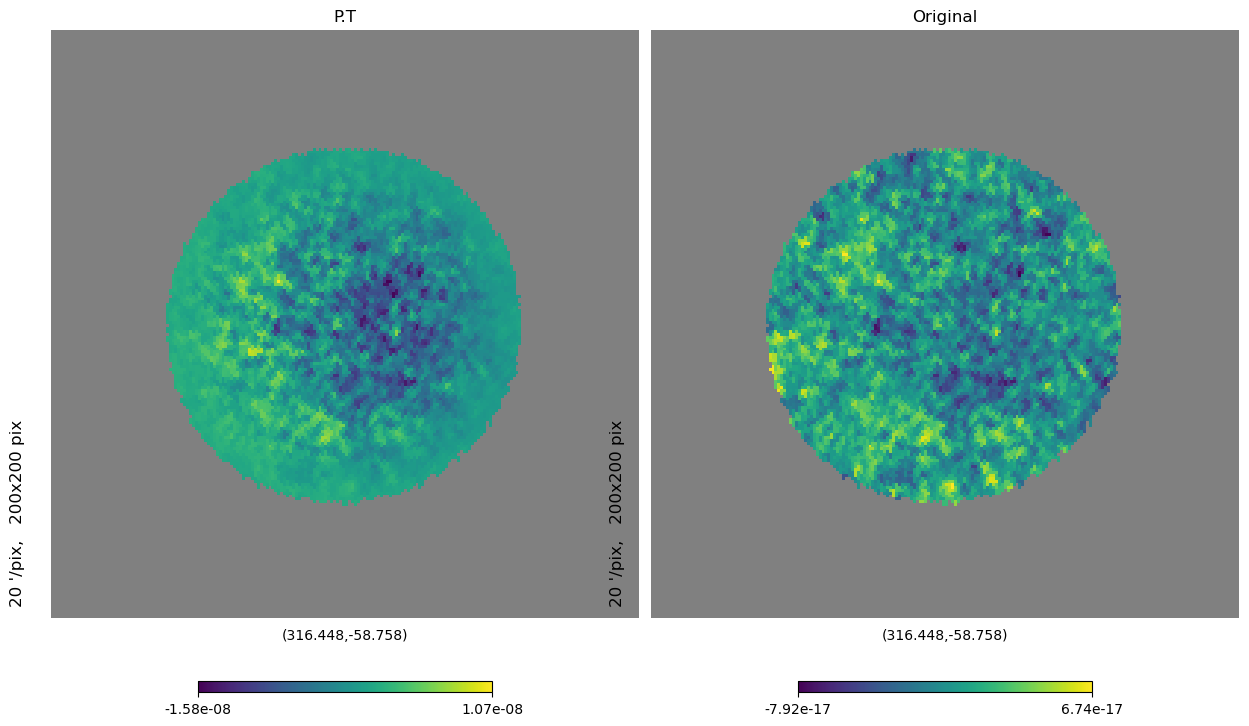

In [78]:
plt.figure(figsize = (12,8))

FATUs_projected_masked = op_proj.T(PFATUs)
FATUs_projected_masked[unseen, :] = hp.UNSEEN
hp.gnomview(FATUs_projected_masked[:,0], rot = center, reso = 20, sub = (1,2,1), title = 'P.T')


FATUs_masked = FATUs
FATUs_masked[unseen, :] = hp.UNSEEN
hp.gnomview(FATUs[:,0], rot = center, reso = 20, sub = (1,2,2), title = 'Original')

In [79]:
diff_PT_I = FATUs_projected_masked[:,0] - FATUs[:,0]
diff_PT_I[unseen] = hp.UNSEEN

In [80]:
diff_PT_Q = FATUs_projected_masked[:,1] - FATUs[:,1]
diff_PT_Q[unseen] = hp.UNSEEN

In [81]:
diff_PT_U = FATUs_projected_masked[:,2] - FATUs[:,2]
diff_PT_U[unseen] = hp.UNSEEN

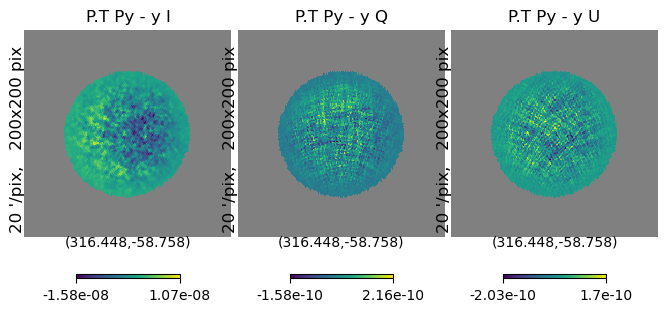

In [82]:
hp.gnomview(diff_PT_I, rot = center, reso = 20, sub = (1,3,1), title='P.T Py - y I')
hp.gnomview(diff_PT_Q, rot = center, reso = 20, sub = (1,3,2), title='P.T Py - y Q')
hp.gnomview(diff_PT_U, rot = center, reso = 20, sub = (1,3,3), title='P.T Py - y U')

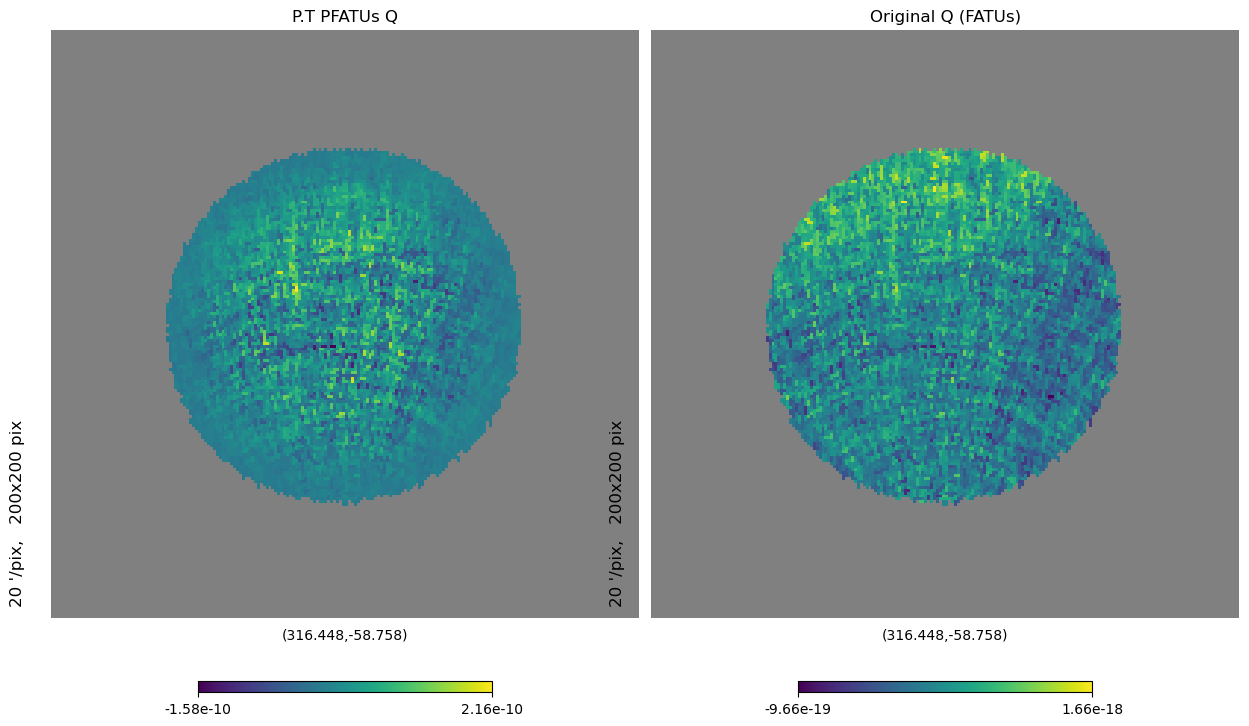

In [83]:
plt.figure(figsize = (12,8))

FATUs_projected_masked = op_proj.T(PFATUs)
FATUs_projected_masked[unseen, :] = hp.UNSEEN
hp.gnomview(FATUs_projected_masked[:,1], rot = center, reso = 20, sub = (1,2,1), title = 'P.T PFATUs Q')


FATUs_masked = FATUs
FATUs_masked[unseen, :] = hp.UNSEEN
hp.gnomview(FATUs[:,1], rot = center, reso = 20, sub = (1,2,2), title = 'Original Q (FATUs)')

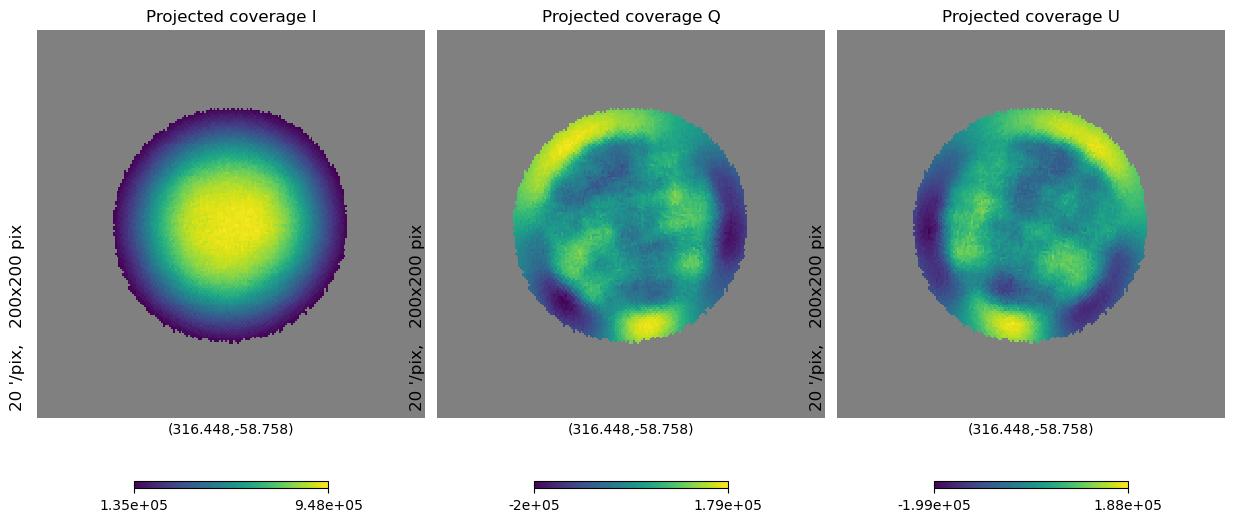

In [84]:
projection_cov[unseen, :] = hp.UNSEEN
plt.figure(figsize = (12,8))
hp.gnomview(projection_cov[:,0], rot = center, reso = 20, title = 'Projected coverage I', sub = (1,3,1))
hp.gnomview(projection_cov[:,1], rot = center, reso = 20, title = 'Projected coverage Q', sub = (1,3,2))
hp.gnomview(projection_cov[:,2], rot = center, reso = 20, title = 'Projected coverage U', sub = (1,3,3))

In [85]:
FATUs_projected_masked_cvc = np.zeros(FATUs_projected_masked.shape)

In [86]:
#corrected by coverage
FATUs_projected_masked_cvc[:,0] = FATUs_projected_masked[:,0] / projection_cov[:,0]
FATUs_projected_masked_cvc[:,1] = FATUs_projected_masked[:,1] / projection_cov[:,0]
FATUs_projected_masked_cvc[:,2] = FATUs_projected_masked[:,2] / projection_cov[:,0]

FATUs_projected_masked_cvc[:,0][FATUs_projected_masked_cvc[:,0] == 1] = hp.UNSEEN
FATUs_projected_masked_cvc[:,1][FATUs_projected_masked_cvc[:,1] == 1] = hp.UNSEEN
FATUs_projected_masked_cvc[:,2][FATUs_projected_masked_cvc[:,2] == 1] = hp.UNSEEN

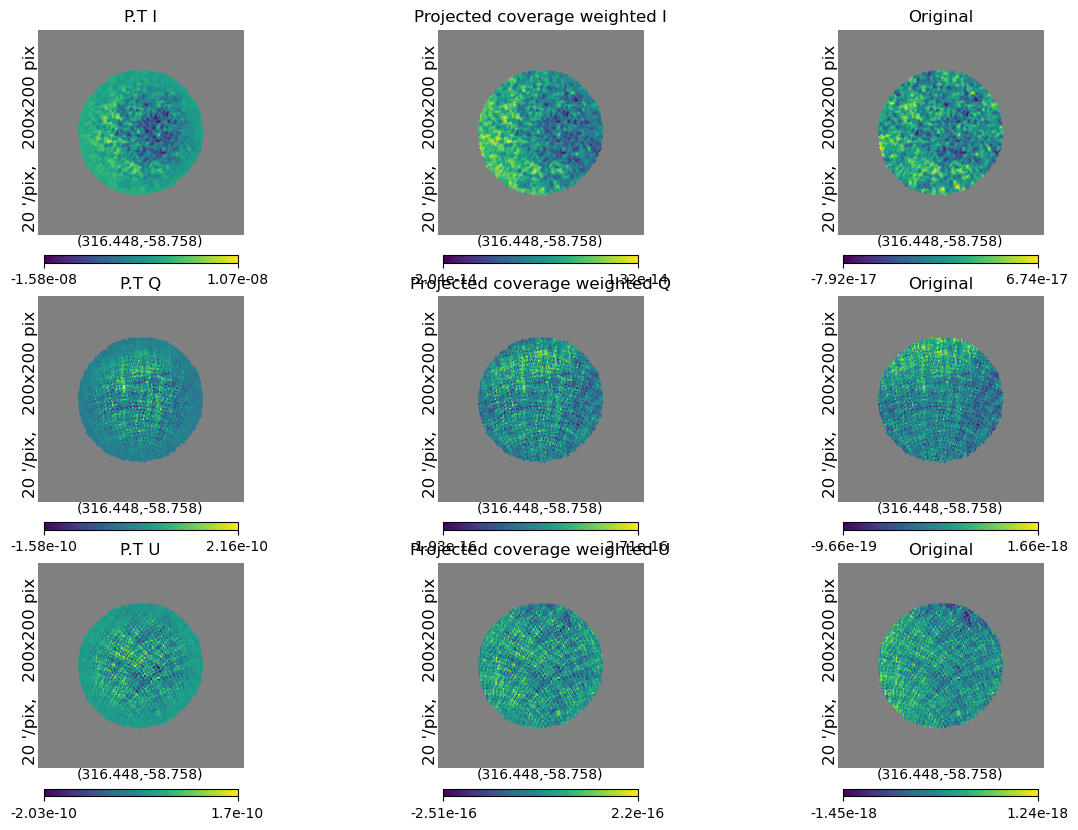

In [87]:
plt.figure(figsize = (12,8))
pol_str = ['I', 'Q', 'U']
for i in range(3):
    hp.gnomview(FATUs_projected_masked[:,i], rot = center, reso = 20, sub = (3,3,i*3+1), title = 'P.T '+pol_str[i])
    hp.gnomview(FATUs_projected_masked_cvc[:,i], rot = center, reso = 20, title = 'Projected coverage weighted '+pol_str[i], sub = (3,3,i*3+2))
    hp.gnomview(FATUs[:,i], rot = center, reso = 20, sub = (3,3,i*3+3), title = 'Original')

In [88]:
sky_i = FATUs_projected_masked_cvc[:,0]

In [89]:
ring2nest_np = hp.ring2nest(nside, np.arange(12*nside**2))

In [90]:
sky_i_nest = np.zeros(sky_i.shape)  # same shape
sky_i_nest[ring2nest_np] = sky_i

In [91]:
def generate_sky_tod_pairs(d, q, s, num_samples, acquisition, op_proj, op_filter, op_aperture_integration, op_unit_conversion):
    """
    Generates multiple (Sky, TOD) pairs for training. These are TODs only affected with operators upto and including the projection !

    num_samples: Number of training samples
    acquisition: QUBIC acquisition object (contains operators)
    op_proj: Projection operator (H)
    op_filter, op_aperture_integration, op_unit_conversion: Instrument effects

    Returns:
    - sky_list: List of generated sky maps (num_samples, n_pix, 3)
    - tod_list: List of generated TODs (num_samples, n_det, n_time, 3)
    """

    sky_list = []
    tod_list = []
    
    for i in tqdm(range(num_samples), desc="Generating sky-TOD pairs"):
        # 1) Generate a random sky realization
        seed = np.random.randint(1, 42)  # Different seed per sample
        sky_config = {'cmb': 42, 'dust': 'd0'}
        Qubic_sky = qss.Qubic_sky(sky_config, d)
        sky_map = Qubic_sky.get_simple_sky_map()[0]  # (n_pix, 3)

        # Ensure sky_map is properly shaped (n_pix, 3)
        if sky_map.shape[-1] != 3:
            raise ValueError("Expected sky map shape (n_pix, 3), but got", sky_map.shape)

        # 2) Apply convolution operator
        convolution = acquisition.get_convolution_peak_operator()
        convolved_maps = convolution(sky_map)  

        # 3) Apply instrumental effects
        sky_before_proj = op_filter(q)(
            op_aperture_integration(q)(
                op_unit_conversion(q, s)(
                    convolved_maps
                )
            )
        )

        # 4) Apply projection to get TOD
        tod_after_proj = op_proj(sky_before_proj)  # (n_det, n_time, 3)

        # Store results
        sky_list.append(sky_before_proj)  # Store true sky
        tod_list.append(tod_after_proj)  # Store TOD

    return np.array(sky_list), np.array(tod_list)

In [92]:
num_samples = 10

sky_list, tod_list = generate_sky_tod_pairs(d, q, s, num_samples, acquisition, op_proj, op_filter, op_aperture_integration, op_unit_conversion)

Generating sky-TOD pairs:   0%|          | 0/10 [00:00<?, ?it/s]

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
Generating sky-TOD pairs: 100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


## High order correction

In [94]:
# ths reading of projection is based on the code for preconditioner where its better explained which entry is what in P
nrows      = P.shape[0]          # = n_detectors × n_time
ncolmax    = P.matrix.ncolmax    # = 9 (number of saved peaks)
nnz        = nrows * ncolmax     # total non‑zero entries

# column indices are taken directly from the sparse structure
cols = torch.from_numpy(P.matrix.data.index.reshape(-1)).long()        # (nnz,)

# for every row we have ncolmax non‑zero entries -> repeat each row index ncolmax times
rows = torch.arange(nrows, dtype=torch.long).repeat_interleave(ncolmax)  # (nnz,)

# the stored amplitude (before the polarisation rotation) is r11
vals = torch.from_numpy(P.matrix.data.r11.reshape(-1)).float()           # (nnz,)

#P_coo = torch.sparse_coo_tensor(
 #   torch.stack([rows, cols]),    # (2, nnz)
  #  vals,                         # (nnz,)
   # size=P.shape,                 # (n_tod , n_pix) or (n_tod , 3·n_pix)
    #dtype=torch.float32
#)


In [95]:
rows = torch.from_numpy(P.matrix.data.index.ravel())
cols = torch.arange(int(np.prod(P.shapein)), dtype=torch.long).repeat_interleave(P.matrix.ncolmax)
vals = torch.from_numpy(P.matrix.data.r11.ravel())
#P_coo  = torch.sparse_coo_tensor(
 #           torch.stack([rows, cols]),
  #          vals,
   #         size=P.shape,  # (ntod , npix) or (ntod, 3*npix)
    #        dtype=torch.float32)

class PTLayer(nn.Module):
    def __init__(self, P_coo):
        super().__init__()
        self.register_buffer("Pt", P_coo.t())   # store P^T as buffer

    def forward(self, tod):
        # tod shape: (batch, ntod)
        return torch.sparse.mm(self.Pt, tod.T).T   # -> (batch, npix)

### Weighted P.T correction

In [96]:
import torch
import torch.nn as nn
import numpy as np
import healpy as hp
from tqdm import tqdm
from pygsp import graphs
import torch_geometric.nn as gnn

class TODToSky(nn.Module):
    """
    A PyTorch module that applies weighted P^T to reconstruct the sky from the TOD.
    """

    def __init__(self, P_operator, projection_cov, seen_indexes_ring):
        super().__init__()
        self.P_operator = P_operator  
        self.projection_cov = torch.tensor(projection_cov, dtype=torch.float32, requires_grad=False)
        self.seen_indexes_ring = seen_indexes_ring
    
    def forward(self, tod_tensor):
        """
        Applies weighted P^T to reconstruct the sky.

        tod_tensor: (batch, n_det, n_time, stokes)
        Returns: sky_tensor (batch, n_pix, stokes)
        """
        batch_size = tod_tensor.shape[0]

        sky_list = []
        for i in range(batch_size):
            with torch.no_grad():
                prvr_tod_np = tod_tensor[i].cpu().numpy()
                prvr_sky_np = self.P_operator.T(prvr_tod_np)
                prvr_sky_torch = torch.from_numpy(prvr_sky_np).to(tod_tensor.device, non_blocking=True)
                
                # Weighted by coverage:
                prvr_sky_torch[:, 0] /= self.projection_cov
                prvr_sky_torch[:, 1] /= self.projection_cov
                prvr_sky_torch[:, 2] /= self.projection_cov

                sky_list.append(prvr_sky_torch)

        sky_tensor = torch.stack(sky_list, dim=0)


        return sky_tensor


class LinearCorrectionNet(nn.Module):
    """
    A GNN-based model that learns to correct the naive P^T reconstruction
    using a graph representation of the sky. This is just to correct the scaling. 
    """

    def __init__(self, input_dim, hidden_dim, output_dim, initial_scale = torch.tensor(1e-3)):
        super().__init__()

        self.scale_layer = nn.Linear(input_dim, input_dim, bias=False) #ovaj nije bas dobar
        #self.scale_layer.weight.data.fill_(initial_linear_scale)  
        
        
        self.scale_factor = nn.Parameter(initial_scale)
        self.bias = nn.Parameter(torch.tensor(0.))

        self.sharpening_layer = nn.Linear(output_dim, output_dim, bias=False)
        #torch.nn.init.eye_(self.sharpening_layer.weight)
        self.sharpening_layer.weight.data *= 1.02
        

    def forward(self, x, edge_index):
        # x is the naive sky (P^T) input
        #x = self.scale_layer(x)  ili donji
        x = x * self.scale_factor + self.bias
        
        #x = self.scale_layer(x + out)
        #x = self.sharpening_layer(x)

        return x 


class TrainableInverseProjection(nn.Module):
    """
    A trainable version of the inverse projection operator.

    - Uses H^T for initial reconstruction
    - Learns corrections via Graph Neural Network
    - Outputs a partial graph representation
    """

    def __init__(self, P_operator, projection_cov, seen_indexes_ring, nside, hidden_dim=128):
        super().__init__()
        self.P_operator = P_operator
        self.nside = nside
        self.seen_indexes_ring = torch.tensor(seen_indexes_ring, dtype=torch.float32)
        self.seen_indexes_nest = torch.tensor(hp.ring2nest(self.nside, seen_indexes_ring), dtype=torch.long)

        n_pix = 12 * nside**2
        ring2nest_np = hp.ring2nest(nside, np.arange(n_pix))  # returns a np array
        self.ring2nest = torch.from_numpy(ring2nest_np).long()
        
        # Naive H^T reconstruction layer
        self.reconstruction = TODToSky(P_operator, projection_cov, seen_indexes_ring)

        # Trainable GNN correction for each Stokes parameter (ode nisan stavila da coverage utjece na q i u)
        self.lnn_I = LinearCorrectionNet(2, hidden_dim, 1, torch.tensor(1e-3)) # prva je 2 za coverage
        self.lnn_Q = LinearCorrectionNet(2, hidden_dim, 1, torch.tensor(1e-2))
        self.lnn_U = LinearCorrectionNet(2, hidden_dim, 1, torch.tensor(1e-2))

    def forward(self, tod_tensor):
        """
        Applies H^T, builds the graph, and corrects the sky using GNN.
        """
        batch_size = tod_tensor.shape[0]

        reconstructed_skies = [] 
        sky_tensor = self.reconstruction(tod_tensor)  # (batch_size, n_pix, stokes)

        for i in range(batch_size):
            #prvo cilo nebo u nest
            sky_i = sky_tensor[i]
            n_pix = sky_i.shape[0]
            sky_i_nest = torch.zeros_like(sky_i)  
            sky_i_nest[self.ring2nest] = sky_i
            
            
            # 3) Extract partial region
            I_partial = sky_i_nest[self.seen_indexes_nest, 0]
            Q_partial = sky_i_nest[self.seen_indexes_nest, 1]
            U_partial = sky_i_nest[self.seen_indexes_nest, 2]

            
            G_sky_I = healpix_graph(nside=self.nside, nest=True)

            # Create masked graph (only observed pixels)
            G_sky_I_partial = G_sky_I.subgraph(self.seen_indexes_nest.cpu().numpy())

            # Convert graph adjacency to edge_index format for PyTorch Geometric
            edge_index = torch.tensor(G_sky_I_partial.W.nonzero(), dtype=torch.long,
                              device=sky_tensor.device)

            # Scale the Stokes parameters to be close to 1, and divide later with the same factor, this is just so
            # the GNN receives numbers around 1 (not around 1e-30) for numerical stability
            I_partial_scaled = I_partial * 1e18
            Q_partial_scaled = Q_partial * 1e21
            U_partial_scaled = U_partial * 1e21

            
            x_I_scaled = I_partial_scaled.unsqueeze(-1)
            x_Q_scaled = Q_partial_scaled.unsqueeze(-1)
            x_U_scaled = U_partial_scaled.unsqueeze(-1)

            delta_x_I_hat_scaled = self.lnn_I(x_I_scaled, edge_index)  # shape (N_observed, 1)
            delta_x_Q_hat_scaled = self.lnn_Q(x_Q_scaled, edge_index)
            delta_x_U_hat_scaled = self.lnn_U(x_U_scaled, edge_index)

            delta_x_I_hat = delta_x_I_hat_scaled / 1e18  # shape (N_observed, 1), rescale the factor we added back
            delta_x_Q_hat = delta_x_Q_hat_scaled / 1e21
            delta_x_U_hat = delta_x_U_hat_scaled / 1e21

            # Deltas are returned (the correction on top of propagated value), if you want you can assign a buffer and also return the map in full scale:
            x_I = x_I_scaled / 1e18 
            x_Q = x_Q_scaled / 1e21
            x_U = x_U_scaled / 1e21

            reconstructed_skies.append((delta_x_I_hat, delta_x_Q_hat, delta_x_U_hat))
        
        return reconstructed_skies

In [97]:
def train_inverse_projection(sky_list, tod_list, num_samples,
                             P_operator, nside, seen_indexes_ring,
                             n_epochs=100, lr=1e-3, batch_size=1):
    """
    Generates training data and trains the inverse projection model.

    Arguments:
    ----------
    num_samples : int
        Number of (sky, TOD) pairs to generate
    acquisition : object
        (Whatever object or parameters you need for data gen)

    op_proj, op_filter, op_aperture_integration, op_unit_conversion : 
        Additional operators used to generate or filter data.
    
    P_operator : PyOperators-like object
        The projection matrix (for applying P^T in reconstruction).
    
    coverage_map : np.array or torch.Tensor
        Coverage array for masking (same shape as the sky).
    
    nside : int
        HEALPix resolution of the sky.
    
    seen_indexes_ring : list or 1D array
        Pixel indices (in ring ordering) that are "observed".
    
    n_epochs : int
        Number of training epochs.
    
    lr : float
        Learning rate.
    
    batch_size : int
        Batch size.

    Returns:
    --------
    model : TrainableInverseProjection
        The trained inverse projection model.
    """

    # Choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1) Generate training data (but now its passed as argument)
    #sky_list, tod_list = generate_sky_tod_pairs(
     #   d, q, s, num_samples, acquisition, 
      #  op_proj, op_filter, 
       # op_aperture_integration, op_unit_conversion)

    # 2) Convert to torch Tensors
    sky_tensor = torch.tensor(np.array(sky_list), dtype=torch.float32, device=device)
    # shape: (num_samples, n_pix, 3)

    tod_tensor = torch.tensor(np.array(tod_list), dtype=torch.float32, device=device)
    # shape: (num_samples, n_det, n_time, 3)
    
    # 3) Initialize the trainable inverse projection model
    #    (Make sure 'projection_cov' is passed in correctly, e.g. coverage_map or coverage_map[:,0] because there are 3 polarisations so 3 coverages)
    model = TrainableInverseProjection(
        P_operator,
        projection_cov=projection_cov[:,0],   
        seen_indexes_ring=seen_indexes_ring,
        nside=nside
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0)

    optimizer = torch.optim.Adam([
        {'params': model.lnn_I.scale_factor, 'lr': 1e-1},
        {'params': model.lnn_I.bias, 'lr': 1e-3},
        {'params': model.lnn_Q.scale_factor, 'lr': 1e-1},
        {'params': model.lnn_Q.bias, 'lr': 1e-3},
        {'params': model.lnn_U.scale_factor, 'lr': 1e-1},
        {'params': model.lnn_U.bias, 'lr': 1e-3},
    ], lr=1e-3)

    # Convert seen indexes to torch on device (just for consistency in the training loop)
    seen_indexes_ring = torch.tensor(seen_indexes_ring, dtype=torch.long, device=device)
    n_pix = 12 * nside**2

    ring2nest_np = hp.ring2nest(nside, np.arange(n_pix))
    ring2nest_torch = torch.from_numpy(ring2nest_np).long().to(device)

    
    seen_indexes_nest = model.seen_indexes_nest.to(device)

    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        # Sample a batch from your dataset
        batch_indices = np.random.choice(num_samples, batch_size, replace=num_samples > batch_size)
        tod_batch = tod_tensor[batch_indices]  # (batch_size, n_det, n_time, 3)
        sky_batch = sky_tensor[batch_indices]  # (batch_size, n_pix, 3)

        # Forward pass: model returns a list of (x_I_hat, x_Q_hat, x_U_hat)
        reconstructed_skies = model(tod_batch)

        loss_total = 0.0

        # For each sample in the batch
        for i, (x_I_hat, x_Q_hat, x_U_hat) in enumerate(reconstructed_skies):
            # True sky for the same partial region (observed pixels):
            sky_ring_i = sky_batch[i]             # (n_pix, 3) in ring
            sky_nest_i = torch.zeros_like(sky_ring_i)
            sky_nest_i[ring2nest_torch] = sky_ring_i 
            
            sky_true_I = sky_nest_i[seen_indexes_nest, 0]  # shape (num_seen,)
            sky_true_Q = sky_nest_i[seen_indexes_nest, 1]
            sky_true_U = sky_nest_i[seen_indexes_nest, 2]

            # GNN outputs are shape (num_seen, 1); remove last dim
            pred_I = x_I_hat.squeeze(-1) 
            pred_Q = x_Q_hat.squeeze(-1) 
            pred_U = x_U_hat.squeeze(-1) 

            #print(pred_I)
            # ovo je relativni mse loss

            loss_I = torch.mean((pred_I - sky_true_I)**2) 
            loss_Q = torch.mean((pred_Q - sky_true_Q)**2) 
            loss_U = torch.mean((pred_U - sky_true_U)**2) 

            loss = loss_I + loss_Q + loss_U 
            loss_total += loss

        loss_total /= batch_size

        loss_total.backward()
        
        print(loss_total)
        #for name, param in model.named_parameters():
         #   if param.grad is None:
          #      print(f"{name} has no grad!")
           # else:
            #    print(f"{name} grad mean = {param.grad.mean().item():.3e}")
        
        optimizer.step()
    
        print(f"Epoch {epoch}, Loss={loss_total.item():.6e}", " pred_I grad_fn =", pred_I.grad_fn)

    return model


In [98]:
n_epochs = 10
lr = 1e-3

trained_model = train_inverse_projection(sky_list, tod_list, num_samples,
                             op_proj, nside, seen_indexes_ring,
                             n_epochs=n_epochs, lr=lr, batch_size=1)

print("Training completed!")

tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 0, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf347010>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 1, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf3aa140>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 2, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf344c70>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 3, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf3abe20>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 4, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf3474c0>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 5, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf3a9780>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 6, Loss=2.921357e-34  pred_I grad_fn = <SqueezeBackward1 object at 0x77caaf344040>
tensor(2.9214e-34, grad_fn=<DivBackward0>)
Epoch 7, Loss=2.921357e-34  pred_

In [99]:
example_no = 8

In [100]:
trained_model.eval()

device = next(trained_model.parameters()).device
tod_sample = torch.tensor(tod_list[example_no], dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension

# Run the trained model on the TOD sample
with torch.no_grad():
    sky_I_reconstructed, sky_Q_reconstructed, sky_U_reconstructed = trained_model(tod_sample)[0]

In [101]:
def mask_map_unseen(sky_map, unseen):
    sky_map[unseen] = hp.UNSEEN
    return sky_map

In [102]:
def expand_ring_masked_map(sky_map_reconstructed, seen_indexes_ring, nside = 256):
    reconstructed_map_full = np.zeros(12*nside**2)
    reconstructed_map_full.fill(hp.UNSEEN)
    reconstructed_map_full[seen_indexes_ring] = sky_map_reconstructed
    return reconstructed_map_full

In [103]:
def expand_nest_masked_map(sky_map_reconstructed, seen_indexes_nest, nside = 256):
    reconstructed_map_full = np.zeros(12*nside**2)
    reconstructed_map_full.fill(hp.UNSEEN)
    reconstructed_map_full[seen_indexes_nest] = sky_map_reconstructed
    return reconstructed_map_full

In [104]:
def nest2ring_masked_map(sky_map_reconstructed, seen_indexes_nest, nside = 256):
    reconstructed_map_nest = np.zeros(12*nside**2)
    reconstructed_map_nest[seen_indexes_nest] = sky_map_reconstructed
    reconstructed_map_ring = hp.reorder(reconstructed_map_nest, n2r = True)
    return reconstructed_map_ring

In [105]:
def ring2nest_masked_map(sky_map_reconstructed, seen_indexes_ring, nside=256):
    reconstructed_map_ring = np.zeros(12*nside**2)
    reconstructed_map_ring[seen_indexes_ring] = sky_map_reconstructed
    reconstructed_map_nest = hp.reorder(reconstructed_map_ring, r2n = True)
    return reconstructed_map_nest

In [106]:
def verify_nest2ring_masked_map(sky_map_reconstructed, seen_indexes_nest, nside=256):
    full_map_nest = np.zeros(12 * nside**2)
    full_map_nest[seen_indexes_nest] = sky_map_reconstructed.flatten()
    
    full_map_ring = hp.reorder(full_map_nest, n2r=True)
    
    seen_indexes_ring = hp.nest2ring(nside, np.array(seen_indexes_nest))
    
    values_nest = full_map_nest[seen_indexes_nest]
    values_ring = full_map_ring[seen_indexes_ring]
    
    return values_nest, values_ring

# Example usage:
nest_vals, ring_vals = verify_nest2ring_masked_map(sky_I_reconstructed[:,0], seen_indexes_nest, nside=256)
print("Nest values:", nest_vals)
print("Ring values:", ring_vals)


Nest values: [-5.06733242e-18 -6.17578091e-18 -4.64046049e-18 ...  7.32452964e-18
  5.30068710e-18  2.63889351e-18]
Ring values: [-5.06733242e-18 -6.17578091e-18 -4.64046049e-18 ...  7.32452964e-18
  5.30068710e-18  2.63889351e-18]


In [107]:
reconstructed_I_ring = nest2ring_masked_map(sky_I_reconstructed[:,0], seen_indexes_nest, nside)
reconstructed_I_ring = mask_map_unseen(reconstructed_I_ring, unseen)

reconstructed_Q_ring = nest2ring_masked_map(sky_Q_reconstructed[:,0], seen_indexes_nest, nside)
reconstructed_Q_ring = mask_map_unseen(reconstructed_Q_ring, unseen)

reconstructed_U_ring = nest2ring_masked_map(sky_U_reconstructed[:,0], seen_indexes_nest, nside)
reconstructed_U_ring = mask_map_unseen(reconstructed_U_ring, unseen)

In [108]:
example_reconstruction_I = reconstructed_I_ring
example_reconstruction_Q = reconstructed_Q_ring
example_reconstruction_U = reconstructed_U_ring

In [109]:
example_original_I = sky_list[example_no, :, 0]
example_original_I[unseen] = hp.UNSEEN

#example_reconstruction_I[seen_indexes_ring] = rescale_to_range(example_reconstruction_I[seen_indexes_ring], example_original_I[seen_indexes_ring])

example_I_diff = example_original_I - example_reconstruction_I
example_I_diff[unseen] = hp.UNSEEN

In [110]:
example_original_Q = sky_list[example_no, :, 1]
example_original_Q[unseen] = hp.UNSEEN

#example_reconstruction_Q[seen_indexes_ring] = rescale_to_range(example_reconstruction_Q[seen_indexes_ring], example_original_Q[seen_indexes_ring])

example_Q_diff = example_original_Q - example_reconstruction_Q
example_Q_diff[unseen] = hp.UNSEEN

In [111]:
example_original_U = sky_list[example_no, :, 2]
example_original_U[unseen] = hp.UNSEEN

#example_reconstruction_U[seen_indexes_ring] = rescale_to_range(example_reconstruction_U[seen_indexes_ring], example_original_U[seen_indexes_ring])


example_U_diff = example_original_U - example_reconstruction_U
example_U_diff[unseen] = hp.UNSEEN

In [112]:
tod_list.shape

(10, 992, 4000, 3)

# Here, we just want the scale to be similar (e.g. 10e-17 for I, as P.T/cov is on a different scale) and its just one scaling factor, the map is NOT CHANGED:

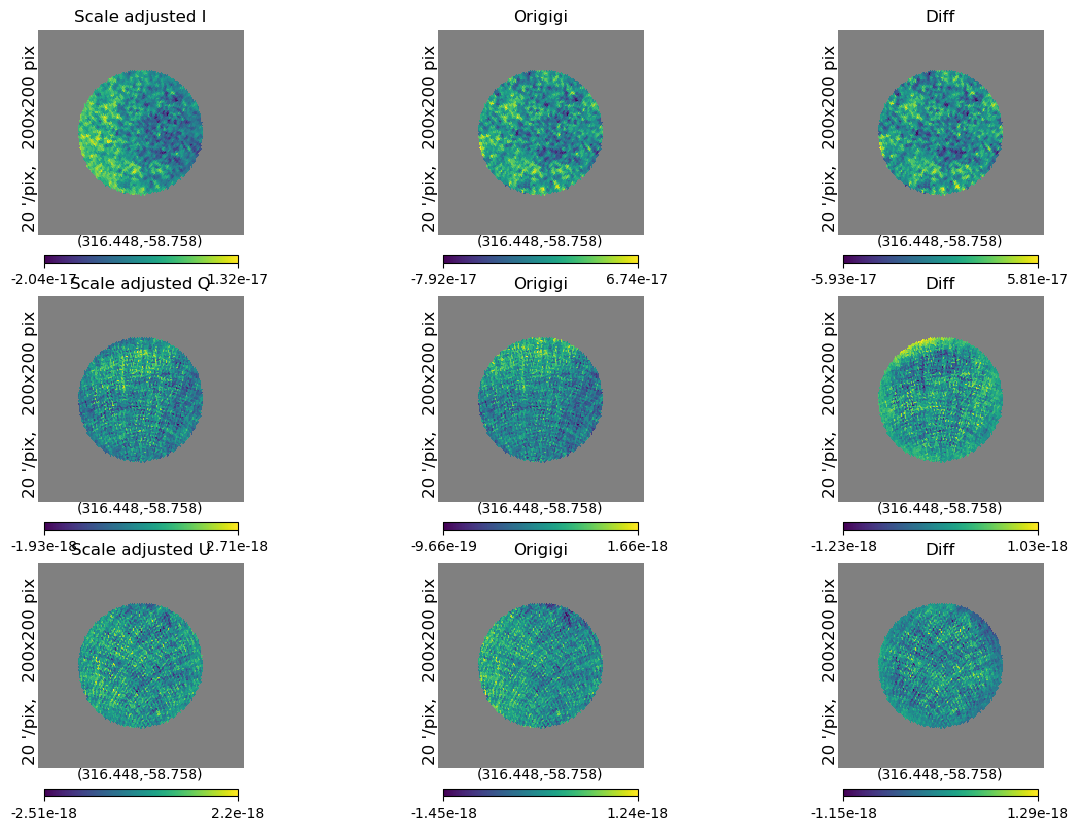

In [116]:
plt.figure(figsize = (12,8))
hp.gnomview(example_reconstruction_I, rot = center, reso = 20, sub = (3,3,1), title = 'Scale adjusted I')
hp.gnomview(example_original_I, rot = center, reso = 20,   sub = (3,3,2), title = 'Origigi')
hp.gnomview(example_I_diff, rot = center, reso = 20,   sub = (3,3,3),  title = 'Diff')

hp.gnomview(example_reconstruction_Q, rot = center, reso = 20, sub = (3,3,4), title = 'Scale adjusted Q')
hp.gnomview(example_original_Q, rot = center, reso = 20,   sub = (3,3,5), title = 'Origigi')
hp.gnomview(example_Q_diff, rot = center, reso = 20,   sub = (3,3,6), title = 'Diff')

hp.gnomview(example_reconstruction_U, rot = center, reso = 20, sub = (3,3,7), title = 'Scale adjusted U')
hp.gnomview(example_original_U, rot = center, reso = 20,   sub = (3,3,8), title = 'Origigi')
hp.gnomview(example_U_diff, rot = center, reso = 20,   sub = (3,3,9), title = 'Diff')


In [117]:
sample = torch.tensor(tod_list[i], dtype=torch.float32, device=device).unsqueeze(0)
trained_model(sample)[0]

(tensor([[-5.0673e-18],
         [-6.1758e-18],
         [-4.6405e-18],
         ...,
         [ 7.3245e-18],
         [ 5.3007e-18],
         [ 2.6389e-18]], grad_fn=<DivBackward0>),
 tensor([[ 1.1979e-18],
         [ 2.1159e-19],
         [ 2.8162e-19],
         ...,
         [ 6.7963e-19],
         [-4.1293e-19],
         [ 9.8475e-20]], grad_fn=<DivBackward0>),
 tensor([[-7.1902e-19],
         [-1.4059e-18],
         [-7.1562e-19],
         ...,
         [ 6.4675e-19],
         [ 2.3495e-19],
         [-2.1187e-19]], grad_fn=<DivBackward0>))

### probaj sljedece, prvo nemoj minjat neba u nest kad si vec unutar mrize, i nemoj ih onda proslijedjivat grafovima. izracunaj nebo kakvo triba izvan i izracunaj COO weight matrix za grafove izvanka. onda samo to proslijedi u jako jednostavnu mrezu

In [118]:
# apply the scaling factor to the sky_list, and prepare them in torch for going to chebyshev inverse of Projection

In [184]:
with torch.no_grad():
        scaled_skies_list = []
        scaled_skies_list_squeezed = []
        for i in range(tod_list.shape[0]):
            sample = torch.tensor(tod_list[i], dtype=torch.float32, device=device).unsqueeze(0)
            sky_I_temp, sky_Q_temp, sky_U_temp = trained_model(sample)[0]
            sky_reconstructed = torch.cat([sky_I_temp, sky_Q_temp, sky_U_temp], dim=-1)  # shape: (21740, 3)
            scaled_skies_list.append(sky_reconstructed.unsqueeze(0))
            scaled_skies_list_squeezed.append(sky_reconstructed)
            
        scaled_skies_list_torch = torch.cat(scaled_skies_list, dim=0)

In [185]:
original_skies_list = []
for i in range(tod_list.shape[0]):
    sample = torch.tensor(sky_list[i], dtype=torch.float32, device=device).unsqueeze(0)
    numpy_sample_I = sample[0][:,0].cpu().numpy()
    numpy_sample_Q = sample[0][:,1].cpu().numpy()
    numpy_sample_U = sample[0][:,2].cpu().numpy()
    sky_I_temp = torch.tensor(hp.reorder(numpy_sample_I, r2n=True)[seen_indexes_nest]).unsqueeze(1)
    sky_Q_temp = torch.tensor(hp.reorder(numpy_sample_Q, r2n=True)[seen_indexes_nest]).unsqueeze(1)
    sky_U_temp = torch.tensor(hp.reorder(numpy_sample_U, r2n=True)[seen_indexes_nest]).unsqueeze(1)
    sky_original = torch.cat([sky_I_temp, sky_Q_temp, sky_U_temp], dim=-1)  # shape: (21740, 3)
    original_skies_list.append(sky_original.unsqueeze(0))
        
    original_skies_list_torch = torch.cat(original_skies_list, dim=0)

In [186]:
print(original_skies_list_torch.shape)
print(scaled_skies_list_torch.shape)

torch.Size([10, 5571, 3])
torch.Size([10, 5571, 3])


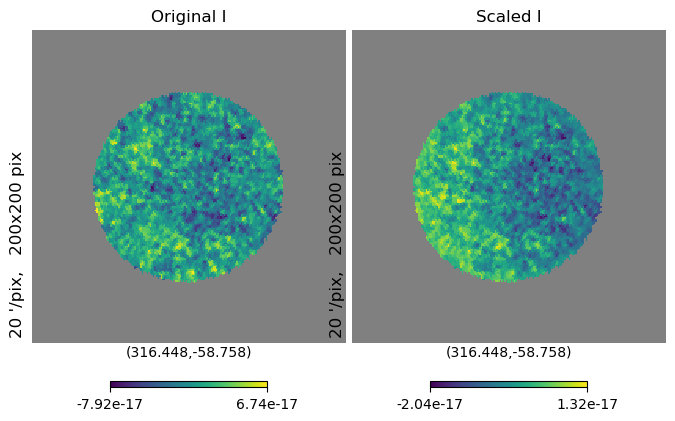

In [187]:
hp.gnomview(expand_nest_masked_map(original_skies_list_torch[0][:,0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,2,1), nest = True, title = 'Original I')
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[0][:,0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,2,2), nest = True, title = 'Scaled I')

In [188]:
G_sky_I = healpix_graph(nside=nside, nest=True)

            # Create masked graph (only observed pixels)
G_sky_I_partial = G_sky_I.subgraph(seen_indexes_nest)

            # Convert graph adjacency to edge_index format for PyTorch Geometric
edge_index = torch.tensor(G_sky_I_partial.W.nonzero(), dtype=torch.long)

# Apart from neighbouring pixels on the sky, we need to know every time 9 pixels were coobserved together by the Projection operator. This is a huge list. Build it once form the scanning strategy and save:

In [124]:
def build_coobs_edges(P, device='cpu', max_pairs_per_row=None):
    """
    Parameters
    ----------
    P : ProjectionOperator   (ntod × npix or ntod × 3*npix)
        The forward operator.  We only look at P.matrix.data.index.
    device : 'cpu' | 'cuda'
    max_pairs_per_row : int or None
        If set, randomly subsample this many pixel–pairs per TOD row
        (useful to keep the edge list small).

    Returns
    -------
    edge_coobs : torch.LongTensor of shape (2, E)
        Undirected edges (i<j) between pixels that appear in the same TOD sample.
        Pixel numbering is whatever numbering P already uses
        (ring or nest – it doesn’t matter for the loss).
    """
    # 1. gather the (ntod , ncolmax) integer array of pixel indices
    idx = P.matrix.data.index          # numpy array
    ntod, ncol = idx.shape

    #  2. build all unordered pairs per row
    #    we will accumulate into two python lists and concat once.
    src, dst = [], []
    rng = np.random.default_rng()

    for row in idx:
        # drop the -1 paddings
        row = row[row >= 0]
        if row.size < 2:
            continue

        if max_pairs_per_row is not None and row.size*(row.size-1)//2 > max_pairs_per_row:
            # heavy row: random subsample K pairs
            chosen = rng.choice(row.size*(row.size-1)//2,
                                size=max_pairs_per_row,
                                replace=False)
            pairs = np.fromiter(
                (comb for k, comb in enumerate(combinations(row, 2)) if k in chosen),
                dtype=[('a', row.dtype), ('b', row.dtype)],
                count=max_pairs_per_row)
            a = pairs['a']; b = pairs['b']
        else:
            # all pairs
            a, b = zip(*combinations(row, 2))
            a = np.fromiter(a, row.dtype);  b = np.fromiter(b, row.dtype)

        # make sure a < b so the edge is undirected
        m = a > b
        a[m], b[m] = b[m], a[m]

        src.append(a);  dst.append(b)

    if not src:      # edge list empty (should not happen)
        return torch.empty(2, 0, dtype=torch.long, device=device)

    src = np.concatenate(src);  dst = np.concatenate(dst)

    #  3. drop duplicates 
    order = np.lexsort((dst, src))
    src, dst = src[order], dst[order]
    keep = np.ones_like(src, dtype=bool)
    keep[1:] = (src[1:] != src[:-1]) | (dst[1:] != dst[:-1])

    edge_coobs = torch.as_tensor(np.stack([src[keep], dst[keep]]),
                                 dtype=torch.long, device=device)
    return edge_coobs


In [125]:
edge_coobs = build_coobs_edges(op_proj)

In [126]:
# you also want to know that per pixel
# seen_indexes is a 1-D numpy / torch array of length 5602
seen_global = np.asarray(seen_indexes)          # global numbers (ring or nest)

# 1. build a mapping global to local 
g2l = {g: i for i, g in enumerate(seen_global)}     

#  2. keep only edges whose BOTH ends are observed 
src_g, dst_g = edge_coobs.cpu().numpy()    # global indices from earlier code
keep = np.isin(src_g, seen_global) & np.isin(dst_g, seen_global)

src_l = np.vectorize(g2l.get)(src_g[keep])    
dst_l = np.vectorize(g2l.get)(dst_g[keep])

edge_coobs_local = torch.as_tensor(
        np.stack([src_l, dst_l]),
        dtype=torch.long, device=device)

print(f'co-obs edges kept: {edge_coobs_local.shape[1]:,d}')


co-obs edges kept: 349,462


# Nest minimal for I, different architectures (skip this if wanted)

Hwre yoou can try GATs, Convs, and simple Neumann expansions (loss not properly developed) as practice on the I stokes

In [ ]:
# use carefully, DataLoader changes instances in place - scaled_skies_list will be scaled through Graphs each time the cell is executed
if False:
    graphs_d = []
    for i in range(scaled_skies_list_torch.size(0)):
        x0_I   = scaled_skies_list_torch[i,:,0:1]                 # (seen_pix,1)
        target = (original_skies_list_torch[i,:,0:1] - x0_I)      # ΔI true (remember we train for CORRECTIONS not maps (called skip connections in NN) - look at the forward call
        graphs_d.append(Data(x=x0_I, y=target, edge_index=edge_index))

    loader = DataLoader(graphs_d, batch_size=2, shuffle=True)

    SCALE = 1e18                       #  1. scale maps again for numerical stability of backpropagation
    for g in graphs_d:
        g.x *= SCALE
        g.y *= SCALE

In [137]:
from torch_geometric.data import Data, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ResidualGCN(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.conv1 = GCNConv(1, hidden)
        self.conv2 = GCNConv(hidden, 1)

    def forward(self, x0, edge_index):
        h = F.relu(self.conv1(x0, edge_index))
        delta = self.conv2(h, edge_index)        # correction ΔI
        return x0 + delta                        # final prediction 
    
class ResidualGAT(nn.Module):
    def __init__(self, hidden=32, heads=4):
        super().__init__()
        self.conv1 = GATConv(1, hidden, heads=heads, concat=True)
        self.conv2 = GATConv(hidden*heads, 1, heads=1, concat=False)

    def forward(self, x0, edge_index):
        h = F.elu(self.conv1(x0, edge_index))
        delta = self.conv2(h, edge_index)
        return x0 + delta

class ResidualCheb(nn.Module):
    def __init__(self, hidden=32, K=3):
        super().__init__()
        self.conv1 = ChebConv(1, hidden, K)
        self.conv2 = ChebConv(hidden, 1, K)

    def forward(self, x0, edge_index):
        h = F.relu(self.conv1(x0, edge_index))
        delta = self.conv2(h, edge_index)
        return x0 + delta
    
class ResidualStack(nn.Module):
    def __init__(self, h=64, K=3, L=3):        # L = number of Cheb layers
        super().__init__()
        self.conv1 = ChebConv(1, h, K)
        self.layers = nn.ModuleList(
            [ChebConv(h, h, K) for _ in range(L-1)])
        self.out    = ChebConv(h, 1, K)

    def forward(self, x, edge):
        h = F.relu(self.conv1(x, edge_index))
        for conv in self.layers[1:]:
            h = F.relu(conv(h, edge) + h)       # local residual
        return x + self.out(h, edge)            # global residual





In [ ]:
model_min = ResidualStack(h = 128, K = 3, L = 4).to(device)
optim_min = torch.optim.Adam(model_min.parameters(), lr=1e-3)   
scheduler = torch.optim.lr_scheduler.StepLR(optim_min, step_size=1000, gamma=0.3)


In [139]:
def edge_mse(pred, true, edge_index):
    src, dst = edge_index
    diff_p = pred[src] - pred[dst]
    diff_t = true[src] - true[dst]
    return (diff_p - diff_t).pow(2).mean()

In [142]:
if True:
    for epoch in range(0, 1001):
        model_min.train()
        tot = 0.
        for batch in loader:
            batch = batch.to(device)
            optim_min.zero_grad()
            pred = model_min(batch.x, batch.edge_index)
            true = batch.x + batch.y                     # scaled ground‑truth
            
            #loss = batch_loss(pred, true, batch.edge_index)
            loss =  F.mse_loss(pred, true)   #  3. scaled MSE 
            loss += 10 * edge_mse(pred, true, batch.edge_index)   #  3. edge MSE
            loss += 10 * edge_mse(pred, true, edge_coobs_local)

            torch.nn.utils.clip_grad_norm_(model_min.parameters(), 1.)   #  3. clip 
            loss.backward()
            optim_min.step()
            tot += loss.item()
        if epoch % 50 == 0:
            print(f'Epoch {epoch:3d} | scaled‑MSE {tot/len(loader):.4e}')


Epoch   0 | scaled‑MSE nan
Epoch  50 | scaled‑MSE nan
Epoch 100 | scaled‑MSE nan
Epoch 150 | scaled‑MSE nan
Epoch 200 | scaled‑MSE nan
Epoch 250 | scaled‑MSE nan
Epoch 300 | scaled‑MSE nan
Epoch 350 | scaled‑MSE nan
Epoch 400 | scaled‑MSE nan
Epoch 450 | scaled‑MSE nan
Epoch 500 | scaled‑MSE nan
Epoch 550 | scaled‑MSE nan
Epoch 600 | scaled‑MSE nan
Epoch 650 | scaled‑MSE nan
Epoch 700 | scaled‑MSE nan
Epoch 750 | scaled‑MSE nan
Epoch 800 | scaled‑MSE nan
Epoch 850 | scaled‑MSE nan
Epoch 900 | scaled‑MSE nan
Epoch 950 | scaled‑MSE nan
Epoch 1000 | scaled‑MSE nan


In [143]:
# proba jednog primjera
model_min.eval()
with torch.no_grad():
    data0 = graphs_d[0].to(device)
    I_pred = model_min(data0.x, data0.edge_index).cpu().numpy().squeeze()   # (5602,)
    I_true = (data0.x + data0.y).cpu().numpy().squeeze()

In [147]:
if True:
    model_min.eval()
    with torch.no_grad():
        data0 = graphs_d[0].to(device)
        I_pred = model_min(scaled_skies_list_torch[i,:,0:1]*1e18, data0.edge_index).cpu().numpy().squeeze()   # (5602,)
        I_true = (original_skies_list_torch[i,:,0:1]*1e18 - scaled_skies_list_torch[i,:,0:1]*1e18).cpu().numpy().squeeze()

In [145]:
# save if you want to continue training (not retrain)
if False:
    torch.save({
    'epoch'    : 10000,
    'model'    : model_min.state_dict(),
    'optimizer': optim_min.state_dict()
    }, 'cheb_10k_edgelossonly.pth')

In [ ]:
hp.gnomview(expand_nest_masked_map(I_true[:], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,1), nest = True, title = 'Original I')
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[0,:,0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,2), nest = True, title = 'Scaled I')
hp.gnomview(expand_nest_masked_map(I_pred[:], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,3), nest = True, title = 'Corrected I')
hp.gnomview(expand_nest_masked_map((I_pred[:] - I_true[:]), seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,4), nest = True, title = 'Difference I')


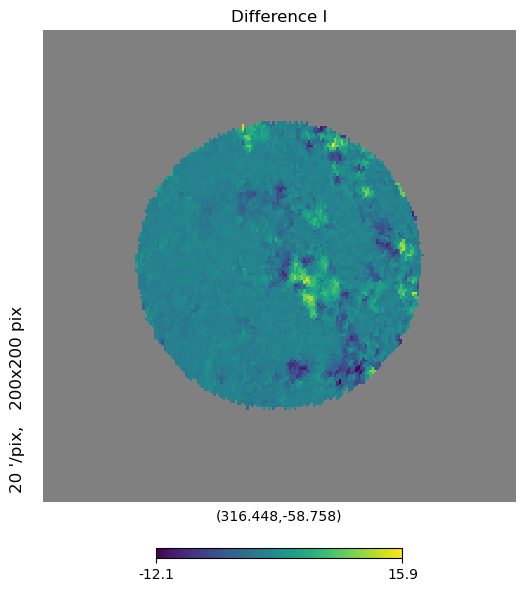

In [ ]:
hp.gnomview(expand_nest_masked_map((I_pred[:] - I_true[:]), seen_indexes_nest, nside), rot = center, reso = 20, nest = True, title = 'Difference I')


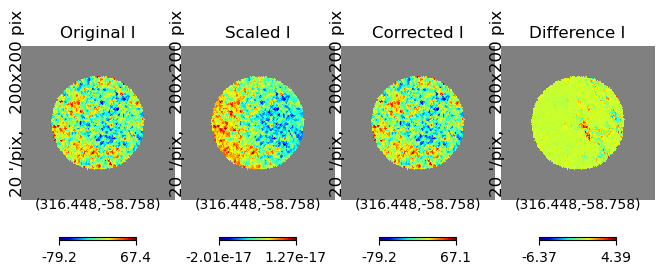

In [385]:
hp.gnomview(expand_nest_masked_map(I_true[:], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,1), nest = True, title = 'Original I', cmap = 'jet')
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[0][:,0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,2), nest = True, title = 'Scaled I', cmap = 'jet')
hp.gnomview(expand_nest_masked_map(I_pred[:], seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,3), nest = True, title = 'Corrected I', cmap = 'jet')
hp.gnomview(expand_nest_masked_map((I_pred[:] - I_true[:]), seen_indexes_nest, nside), rot = center, reso = 20, sub = (1,4,4), nest = True, title = 'Difference I', cmap = 'jet')


# Stacked Cheb for inverse Projection correction

In [189]:
S_I  = 1e17          
S_QU = 1e18          # and again


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [190]:
def build_graphs_IQU(scaled, orig, edge_index, tod_list):
    graphs = []
    for i in range(len(scaled)):
        x0  = torch.stack([
            scaled[i,:,0]*S_I,
            scaled[i,:,1]*S_QU,
            scaled[i,:,2]*S_QU], dim=1)                        # (5602,3)

        y   = torch.stack([
            (orig[i,:,0]-scaled[i,:,0])*S_I,
            (orig[i,:,1]-scaled[i,:,1])*S_QU,
            (orig[i,:,2]-scaled[i,:,2])*S_QU], dim=1)          # (5602,3)

        tod_I = torch.tensor(tod_list[i,:,:,0], dtype=torch.float32).flatten()
        graphs.append(Data(x=x0, y=y, edge_index=edge_index, tod=tod_I))
    return graphs

In [191]:
edge_all = torch.cat([edge_index, edge_coobs_local], dim=1)
edge_all, _ = torch.unique(edge_all, dim=1, sorted=False, return_inverse=True)

In [192]:
graphs_IQU = build_graphs_IQU(scaled_skies_list_torch,
                              original_skies_list_torch,
                              edge_index,
                              tod_list)
loader = DataLoader(graphs_IQU, batch_size=1, shuffle=True)

In [193]:
seen_nest = torch.as_tensor(seen_indexes_nest, dtype=torch.long, device=device)
seen_ring = torch.as_tensor(hp.nest2ring(nside, seen_indexes_nest),
                            dtype=torch.long, device=device)

In [194]:
def full_nest_to_ring(local):
    full = torch.zeros((npix, 3),        
                       dtype=local.dtype, device=local.device)
    full.index_copy_(0, seen_nest, local)
    full.index_copy_(0, seen_ring, local)
    return full         

In [195]:
class SharedCheb3Head(nn.Module):
    def __init__(self, hidden=128, K=3, L=4):
        super().__init__()
        self.enc0  = ChebConv(3, hidden, K)
        self.encs  = nn.ModuleList([ChebConv(hidden, hidden, K) for _ in range(L-1)])

        self.headI = ChebConv(hidden, 1, K)
        self.headQ = ChebConv(hidden, 1, K)
        self.headU = ChebConv(hidden, 1, K)

    def forward(self, x, edge):
        h = F.relu(self.enc0(x, edge))
        for conv in self.encs:
            h = F.relu(conv(h, edge) + h)      # local residual
        dI = self.headI(h, edge);  dQ = self.headQ(h, edge);  dU = self.headU(h, edge)
        return x + torch.cat([dI,dQ,dU], dim=1)   # residual on all 3

In [196]:
net_IQU = SharedCheb3Head().to(device)
optim    = torch.optim.Adam(net_IQU.parameters(), lr=1e-3)
sched    = torch.optim.lr_scheduler.StepLR(optim, step_size=1000, gamma=0.3)

In [197]:
def edge_mse(pred, true, edge_index):
    src, dst = edge_index
    diff_p = pred[src] - pred[dst]
    diff_t = true[src] - true[dst]
    return (diff_p - diff_t).pow(2).mean()

In [198]:
def edge_mse_3(pred, true, edge, weigh_QU = 1.):
    return (edge_mse(pred[:,0], true[:,0], edge) +
            weigh_QU * edge_mse(pred[:,1], true[:,1], edge) +
            weigh_QU * edge_mse(pred[:,2], true[:,2], edge))

In [199]:
λ_pix   = 10.       # pixel MSE 0.0015
λ_geo   = 1.0       # geometric edge loss 0.0041
λ_coobs = 1.0       # co-obs   edge loss 0.0018
λ_phys  =  1e31     # 1e-30

npix = hp.nside2npix(nside)  


In [200]:
def train(network, optimizer, scheduler, loader, epochs=101, λ_pix = 10., λ_geo = 1.0, λ_coobs = 1.0, λ_phys = 10., weigh_QU = 1.):
    for epoch in range(epochs):
        network.train()
        tot = 0.
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            pred = network(batch.x, batch.edge_index)
            true = batch.x + batch.y

            loss_pix = 1000. * λ_pix * F.mse_loss(pred, true)   # --- 3. scaled MSE ---
            loss_geo = 1000. * λ_geo * edge_mse_3(pred, true, batch.edge_index, weigh_QU)   # --- 3. edge MSE ---
            loss_coobs = 1000. * λ_coobs * edge_mse_3(pred, true, edge_coobs_local, weigh_QU)
            loss = loss_pix + loss_geo + loss_coobs
            loss_phys = 0.
            if λ_phys > 0:
            # back to physical units
                pred_phys = torch.stack([pred[:,0]/S_I,
                                        pred[:,1]/S_QU,
                                        pred[:,2]/S_QU], dim=1)
                full_ring = full_nest_to_ring(pred_phys)          # (npix,3) RING
                tod_mod = torch.tensor(
                    op_proj(full_ring.detach().cpu().numpy())[:,:,0].flatten(),
                    dtype=torch.float32, device=device)

                loss_phys = F.mse_loss(tod_mod, batch.tod,
                                                    reduction='mean')
                loss += 1e30 * λ_phys * loss_phys
            
            loss.backward()
            optimizer.step()
            tot += loss.item()
        if epoch % 50 == 0:
            print(f'Epoch {epoch:3d} | scaled‑MSE {tot/len(loader):.4e}')
            print(f'pix_loss: {loss_pix:.4e} | geo_loss: {loss_geo:.4e} | coobs_loss: {loss_coobs:.4e} | phys_loss: {loss_phys:.4e}')
        scheduler.step()

In [ ]:
# train a global correction on all 3 polarisations simultaneously, then properly unmix the projection operator. thirdly, you can do a general loss that includes all factors

In [ ]:
train(net_IQU, optim, sched, loader, epochs=1000, λ_pix = 10., λ_geo = 1.0, λ_coobs = 1.0, λ_phys = 10.)

In [ ]:
train(net_IQU, optim, sched, loader, epochs=1000, λ_pix = 1., λ_geo = 10.0, λ_coobs = 10.0, λ_phys = 1.)

Epoch   0 | scaled‑MSE 3.0344e+04
pix_loss: 3.6472e+02 | geo_loss: 5.6673e+03 | coobs_loss: 1.4545e+04 | phys_loss: 1.7316e-29
Epoch  50 | scaled‑MSE 1.2518e+03
pix_loss: 3.1026e+01 | geo_loss: 7.7006e+02 | coobs_loss: 4.0243e+02 | phys_loss: 4.3517e-30
Epoch 100 | scaled‑MSE 6.2644e+02
pix_loss: 1.2781e+01 | geo_loss: 3.7447e+02 | coobs_loss: 1.4868e+02 | phys_loss: 3.1848e-30
Epoch 150 | scaled‑MSE 3.1644e+02
pix_loss: 7.5277e+00 | geo_loss: 2.1509e+02 | coobs_loss: 1.0715e+02 | phys_loss: 3.0311e-30
Epoch 200 | scaled‑MSE 3.8966e+02
pix_loss: 1.0252e+01 | geo_loss: 1.5387e+02 | coobs_loss: 3.0754e+02 | phys_loss: 4.0532e-30
Epoch 250 | scaled‑MSE 2.3482e+02
pix_loss: 5.2409e+00 | geo_loss: 1.1084e+02 | coobs_loss: 1.2216e+02 | phys_loss: 3.4134e-30
Epoch 300 | scaled‑MSE 1.4829e+02
pix_loss: 2.7260e+00 | geo_loss: 7.8729e+01 | coobs_loss: 5.2971e+01 | phys_loss: 2.8682e-30
Epoch 350 | scaled‑MSE 9.7454e+01
pix_loss: 1.8798e+00 | geo_loss: 6.0213e+01 | coobs_loss: 3.2628e+01 | phys_l

In [ ]:
train(net_IQU, optim, sched, loader, epochs=1000, λ_pix = 10., λ_geo = 10.0, λ_coobs = 10.0, λ_phys = 10., weigh_QU = 2.)

Epoch   0 | scaled‑MSE 3.7733e+01
pix_loss: 6.4244e-01 | geo_loss: 6.5191e+00 | coobs_loss: 1.7944e+00 | phys_loss: 2.8732e-30
Epoch  50 | scaled‑MSE 3.7991e+01
pix_loss: 9.1929e-01 | geo_loss: 6.3783e+00 | coobs_loss: 1.6993e+00 | phys_loss: 2.8352e-30
Epoch 100 | scaled‑MSE 3.7360e+01
pix_loss: 6.6226e-01 | geo_loss: 6.2487e+00 | coobs_loss: 1.7419e+00 | phys_loss: 2.8803e-30
Epoch 150 | scaled‑MSE 3.8484e+01
pix_loss: 6.5269e-01 | geo_loss: 6.0375e+00 | coobs_loss: 1.7011e+00 | phys_loss: 2.8722e-30
Epoch 200 | scaled‑MSE 3.7389e+01
pix_loss: 7.6545e-01 | geo_loss: 5.9426e+00 | coobs_loss: 2.2718e+00 | phys_loss: 2.9140e-30
Epoch 250 | scaled‑MSE 3.6502e+01
pix_loss: 5.6646e-01 | geo_loss: 5.7329e+00 | coobs_loss: 1.3943e+00 | phys_loss: 2.8741e-30
Epoch 300 | scaled‑MSE 3.6268e+01
pix_loss: 5.6485e-01 | geo_loss: 5.6001e+00 | coobs_loss: 1.3344e+00 | phys_loss: 2.8581e-30
Epoch 350 | scaled‑MSE 3.6420e+01
pix_loss: 5.9216e-01 | geo_loss: 5.4833e+00 | coobs_loss: 1.3302e+00 | phys_l

In [ ]:
# or you can continue training from a checkpoint
if False:
    for epoch in range(800, 1000):
        net_IQU.train(); tot = 0.
        for batch in loader:                    # one graph
            batch = batch.to(device)
            optim.zero_grad()

            pred = net_IQU(batch.x, batch.edge_index)   # (5602,3) scaled
            true = batch.x + batch.y

            loss  = λ_pix   * F.mse_loss(pred, true)
            loss += λ_geo   * edge_mse_3(pred, true, batch.edge_index)
            loss += λ_coobs * edge_mse_3(pred, true, edge_coobs_local)

            if λ_phys > 0:
                # back to physical units
                pred_phys = torch.stack([pred[:,0]/S_I,
                                        pred[:,1]/S_QU,
                                        pred[:,2]/S_QU], dim=1)
                full_ring = full_nest_to_ring(pred_phys)          # (npix,3) RING
                tod_mod = torch.tensor(
                    op_proj(full_ring.detach().cpu().numpy())[:,:,0].flatten(),
                    dtype=torch.float32, device=device)

                loss_phys = F.mse_loss(tod_mod, batch.tod,
                                                    reduction='mean')
                loss += λ_phys * loss_phys

            loss.backward()
            torch.nn.utils.clip_grad_norm_(net_IQU.parameters(), 1.)
            optim.step(); sched.step();  tot += loss.item()

        if epoch % 50 == 0:
            print(f"Epoch {epoch:5d} | total loss {tot/len(loader):.3e}")


In [ ]:
if False:
    torch.save({
    'epoch'    : 1200,
    'model'    : net_IQU.state_dict(),
    'optimizer': optim.state_dict()
    }, 'cheb_stokes_cmbdust42_edgelossonly.pth')

In [203]:
checkpoint = torch.load('cheb_stokes_cmbdust42_edgelossonly.pth')
net_IQU.load_state_dict(checkpoint['model'])
optim.load_state_dict(checkpoint['optimizer'])

In [204]:
example_no = 6
net_IQU.eval()
with torch.no_grad():
    g0           = graphs_IQU[example_no].to(device)
    pred_scaled  = net_IQU(g0.x, g0.edge_index).cpu()         # (5602,3)
    true_scaled  = (g0.x + g0.y).cpu()

In [205]:
pred_phys = np.stack([ pred_scaled[:,0]/S_I,
                       pred_scaled[:,1]/S_QU,
                       pred_scaled[:,2]/S_QU ], axis=1)       # (5602,3)
true_phys = np.stack([ true_scaled[:,0]/S_I,
                       true_scaled[:,1]/S_QU,
                       true_scaled[:,2]/S_QU ], axis=1)

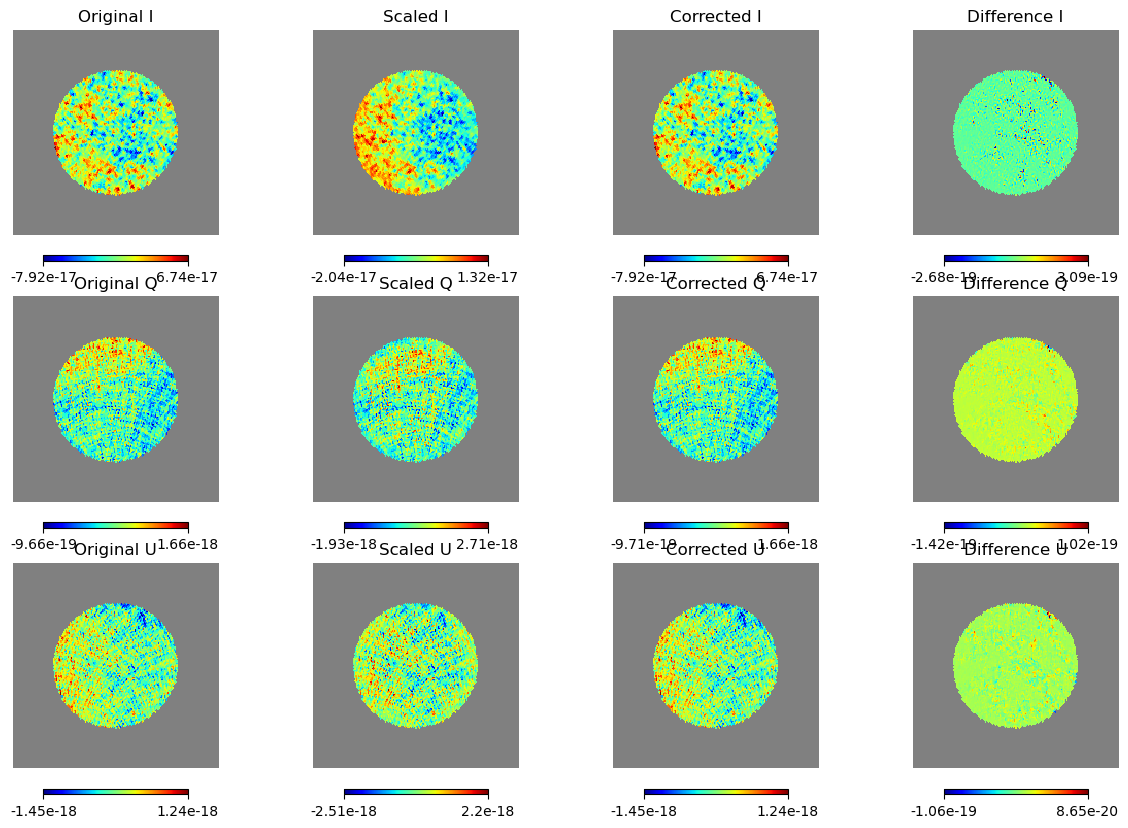

In [206]:
fig = plt.figure(figsize=(12,8))
hp.gnomview(expand_nest_masked_map(true_phys[:,0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,1), nest = True, title = 'Original I', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[example_no][:,0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,2), nest = True, title = 'Scaled I', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(pred_phys[:, 0], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,3), nest = True, title = 'Corrected I', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map((pred_phys[:, 0] - true_phys[:,0]), seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,4), nest = True, title = 'Difference I', cmap = 'jet', notext=True)

hp.gnomview(expand_nest_masked_map(true_phys[:,1], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,5), nest = True, title = 'Original Q', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[example_no][:,1], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,6), nest = True, title = 'Scaled Q', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(pred_phys[:, 1], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,7), nest = True, title = 'Corrected Q', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map((pred_phys[:, 1] - true_phys[:,1]), seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,8), nest = True, title = 'Difference Q', cmap = 'jet', notext=True)

hp.gnomview(expand_nest_masked_map(true_phys[:,2], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,9), nest = True, title = 'Original U', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[example_no][:,2], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,10), nest = True, title = 'Scaled U', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(pred_phys[:, 2], seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,11), nest = True, title = 'Corrected U', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map((pred_phys[:, 2] - true_phys[:,2]), seen_indexes_nest, nside), rot = center, reso = 20, sub = (3,4,12), nest = True, title = 'Difference U', cmap = 'jet', notext=True)



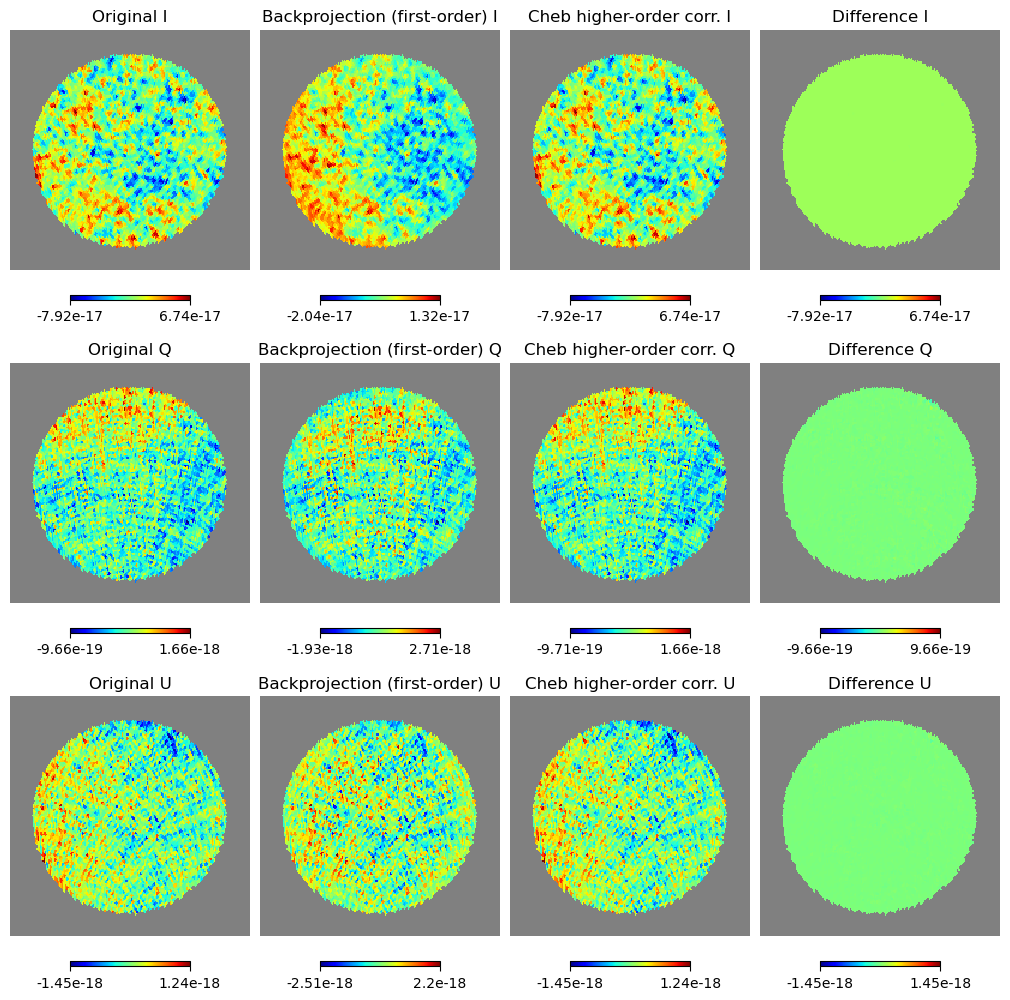

In [207]:
fig = plt.figure(figsize=(10,10))
hp.gnomview(expand_nest_masked_map(true_phys[:,0], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,1), nest = True, title = 'Original I', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[example_no][:,0], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,2), nest = True, title = 'Backprojection (first-order) I', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(pred_phys[:, 0], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,3), nest = True, title = 'Cheb higher-order corr. I', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map((pred_phys[:, 0] - true_phys[:,0]), seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,4), nest = True, title = 'Difference I', cmap = 'jet', notext=True, min = true_phys[:,0].min(), max = true_phys[:,0].max())

hp.gnomview(expand_nest_masked_map(true_phys[:,1], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,5), nest = True, title = 'Original Q', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[example_no][:,1], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,6), nest = True, title = 'Backprojection (first-order) Q', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(pred_phys[:, 1], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,7), nest = True, title = 'Cheb higher-order corr. Q', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map((pred_phys[:, 1] - true_phys[:,1]), seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,8), nest = True, title = 'Difference Q', cmap = 'jet', notext=True, min= true_phys[:,1].min(), max = np.abs(true_phys[:,1].min()))

hp.gnomview(expand_nest_masked_map(true_phys[:,2], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,9), nest = True, title = 'Original U', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(scaled_skies_list_torch[example_no][:,2], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,10), nest = True, title = 'Backprojection (first-order) U', cmap = 'jet', notext=True)
hp.gnomview(expand_nest_masked_map(pred_phys[:, 2], seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,11), nest = True, title = 'Cheb higher-order corr. U', cmap = 'jet', notext=True, min = true_phys[:,2].min(), max = true_phys[:,2].max())
hp.gnomview(expand_nest_masked_map((pred_phys[:, 2] - true_phys[:,2]), seen_indexes_nest, nside), rot = center, reso = 15, sub = (3,4,12), nest = True, title = 'Difference U', cmap = 'jet', notext=True, min = true_phys[:,2].min(), max = np.abs(true_phys[:,2].min()))



# Backprojected to sky

In [208]:
class InverseFilterOperator(nn.Module):
    def __init__(self, qubic_instr):
        super().__init__()
        bw = float(qubic_instr.filter.bandwidth)
        scale = 1.0 / bw if bw > 0 else 1.0           # identity if bw==0
        self.register_buffer('scale', torch.tensor(scale))

    def forward(self, x):
        return x * self.scale   
    

filter_operator = op_filter(q)

#original_sky = torch.randn(786432, 3, dtype=torch.float32)
original_sky = torch.tensor(ATUs, dtype=torch.float64)

sky_after_filter = torch.tensor(filter_operator(original_sky.detach().cpu().numpy()), dtype=torch.float64)

inverse_filter = InverseFilterOperator(q)
recovered_sky = inverse_filter(sky_after_filter)

loss_fn = torch.nn.MSELoss()
print(loss_fn(recovered_sky, original_sky))

recovered_sky_squeezed = recovered_sky.squeeze(0)

tensor(1.3436e-69, dtype=torch.float64)


In [209]:
class InverseApertureIntegration(nn.Module):
    def __init__(self, qubic_instr):
        super().__init__()
        nh = int(np.sum(qubic_instr.horn.open))
        area = float(np.pi * qubic_instr.horn.radeff ** 2)
        scale = 1.0 / (nh * area)
        self.register_buffer('scale', torch.tensor(scale))

    def forward(self, x):
        return x * self.scale


    
aperture_operator = op_aperture_integration(q)

#original_sky = torch.randn(786432, 3, dtype=torch.float32)
original_sky = torch.tensor(TUs, dtype=torch.float64)

sky_after_aperture = torch.tensor(aperture_operator(original_sky.detach().cpu().numpy()), dtype=torch.float64)

inverse_aperture = InverseApertureIntegration(q)

recovered_sky = inverse_aperture(sky_after_aperture)

loss_fn = torch.nn.MSELoss()
print(loss_fn(recovered_sky, original_sky))

recovered_sky_squeezed = recovered_sky.squeeze(0)

tensor(3.1542e-66, dtype=torch.float64)


In [211]:
from scipy.constants import h, k, c
class InverseUnitConversionOperator(nn.Module):
    """
    If scene.absolute == False  (linear regime):
        x_W  → x_K  by dividing with the known linear factor.
    If scene.absolute == True   (non-linear Planck law):
        use a tiny NN approximator that is itself differentiable.
    """
    def __init__(self, qubic_instr, qubic_scene):
        super().__init__()

        nu   = torch.tensor(float(qubic_instr.filter.nu))       
        Ω    = torch.tensor(float(qubic_scene.solid_angle))     
        h,k,c = 6.62607015e-34, 1.380649e-23, 2.99792458e8

        if not qubic_scene.absolute:           
            Tcmb = torch.tensor(float(qubic_scene.temperature)) # K
            x    = h*nu/(k*Tcmb)
            val  = 1e-6 * 2*Ω*h*nu**3/c**2 * x*torch.exp(x)/(torch.expm1(x)**2 * Tcmb)
            self.register_buffer('scale', 1.0/val)
            self.use_nn = False
        else:                                  #  non-linear regime (hope we never have to use this)
            self.nn     = ComplexInversePlanckLawNN()
            self.use_nn = True

    def forward(self, x):
        if self.use_nn:
            return self.nn(x)
        return x * self.scale



class ComplexInversePlanckLawNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(ComplexInversePlanckLawNN, self).__init__()
        
        # Wider neural network to capture the complexity of the non-linear Planck law
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, hidden_size)  
        self.fc4 = nn.Linear(hidden_size, hidden_size // 2)  
        self.fc5 = nn.Linear(hidden_size // 2, output_size)  
        
        # Non-linear activation functions
        self.tanh = nn.Tanh()  
        self.relu = nn.ReLU()  
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.tanh(self.fc3(x))  
        x = self.relu(self.fc4(x))  
        x = self.fc5(x)  
        return x

unit_conversion_operator = op_unit_conversion(q, s)
original_sky = torch.tensor(sky_map[0], dtype=torch.float64)
sky_after_unit_conversion = torch.tensor(unit_conversion_operator(original_sky.detach().cpu().numpy()), dtype=torch.float64)

inverse_unit_conversion = InverseUnitConversionOperator(q, s)
recovered_sky = inverse_unit_conversion(sky_after_unit_conversion)


In [212]:
reconstructed_sky = np.stack([expand_nest_masked_map(pred_phys[:,0], seen_indexes_nest, nside), expand_nest_masked_map(pred_phys[:,1], seen_indexes_nest, nside), expand_nest_masked_map(pred_phys[:,2], seen_indexes_nest, nside)], axis=-1)

In [213]:
reconstructed_sky = inverse_filter(torch.tensor(reconstructed_sky))
reconstructed_sky = inverse_aperture(reconstructed_sky)
reconstructed_sky = inverse_unit_conversion(reconstructed_sky)
reconstructed_sky = reconstructed_sky.squeeze(0)

In [214]:
reconstructed_sky_ring = np.zeros(reconstructed_sky.shape, dtype=np.float64)
reconstructed_sky_ring[:, 0] = hp.reorder(reconstructed_sky[:, 0], nside, n2r = True)
reconstructed_sky_ring[:, 1] = hp.reorder(reconstructed_sky[:, 1], nside, n2r = True)
reconstructed_sky_ring[:, 2] = hp.reorder(reconstructed_sky[:, 2], nside, n2r = True)

reconstructed_sky_ring[unseen,:] = hp.UNSEEN

In [215]:
original_sky = sky_list[8]
original_sky[unseen,:] = hp.UNSEEN

In [216]:
original_sky = inverse_filter(torch.tensor(original_sky))
original_sky = inverse_aperture(original_sky)
original_sky = inverse_unit_conversion(original_sky)
original_sky = original_sky.squeeze(0)

In [217]:
original_sky[unseen,:] = hp.UNSEEN

In [218]:
diff_I = original_sky[:,0] - reconstructed_sky_ring[:,0]
diff_Q = original_sky[:,1] - reconstructed_sky_ring[:,1]
diff_U = original_sky[:,2] - reconstructed_sky_ring[:,2]

In [219]:
diff_I[unseen] = hp.UNSEEN
diff_Q[unseen] = hp.UNSEEN
diff_U[unseen] = hp.UNSEEN

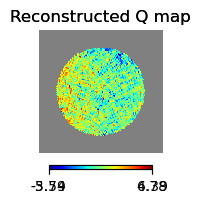

In [231]:
# just to plot at approximately 10 percent error
max_Q = np.max(hp.gnomview(reconstructed_sky_ring[:,1], rot = center, reso = 17,   sub = (3,3,5), title = 'Reconstructed Q map', cmap = 'jet', notext = True, return_projected_map = True, ))
max_U = np.max(hp.gnomview(reconstructed_sky_ring[:,2], rot = center, reso = 17,   sub = (3,3,5), title = 'Reconstructed Q map', cmap = 'jet', notext = True, return_projected_map = True, ))

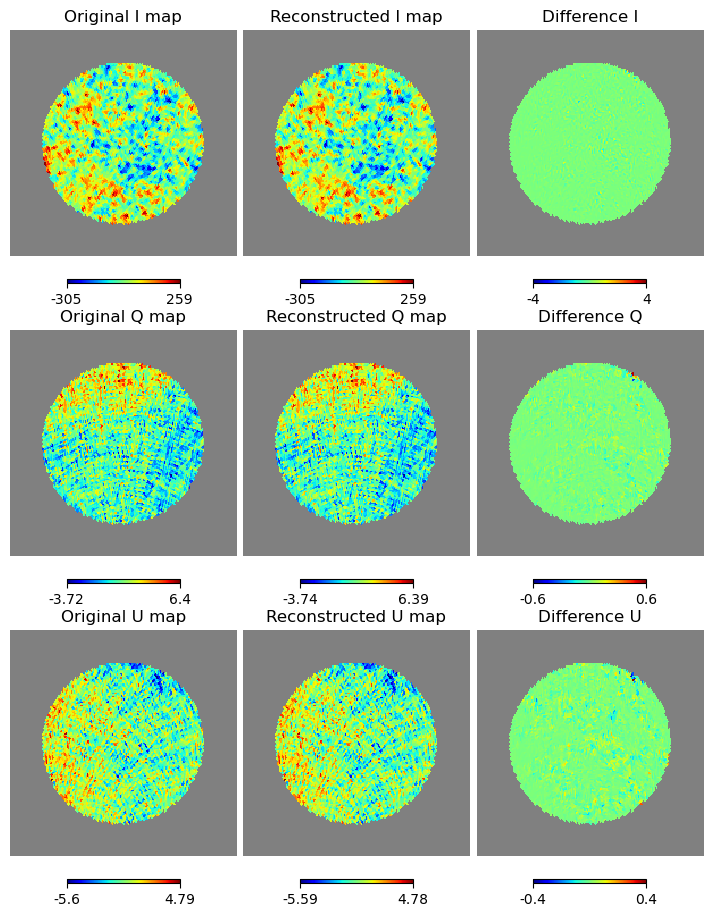

In [233]:
plt.figure(figsize = (7,9))
hp.gnomview(original_sky[:,0], rot = center, reso = 17, sub = (3,3,1), title = 'Original I map', cmap = 'jet', notext=True)
hp.gnomview(reconstructed_sky_ring[:,0], rot = center, reso = 17,   sub = (3,3,2), title = 'Reconstructed I map', cmap = 'jet', notext=True)
hp.gnomview(diff_I, rot = center, reso = 17,   sub = (3,3,3),  title = 'Difference I', min = -4, max = 4, cmap = 'jet', notext=True)

hp.gnomview(original_sky[:,1], rot = center, reso = 17, sub = (3,3,4), title = 'Original Q map', cmap = 'jet', notext = True)
hp.gnomview(reconstructed_sky_ring[:,1], rot = center, reso = 17,   sub = (3,3,5), title = 'Reconstructed Q map', cmap = 'jet', notext = True)
hp.gnomview(diff_Q, rot = center, reso = 17,   sub = (3,3,6),  title = 'Difference Q', min = -int(max_Q)/10, max = int(max_Q)/10, cmap = 'jet', notext = True)

hp.gnomview(original_sky[:,2], rot = center, reso = 17, sub = (3,3,7), title = 'Original U map', cmap = 'jet', notext = True)
hp.gnomview(reconstructed_sky_ring[:,2], rot = center, reso = 17,   sub = (3,3,8), title = 'Reconstructed U map', cmap = 'jet', notext = True)
hp.gnomview(diff_U, rot = center, reso = 17,   sub = (3,3,9),  title = 'Difference U', min = -int(max_U)/10, max = int(max_U)/10, cmap = 'jet', notext = True)

In [ ]:
break

# Differentiating and losses:

In [142]:
def healpix_gradient_masked(sky_map, nside, seen_indexes):
    """
    Compute gradient using valid HEALPix neighbors for observed pixels. All of this should be in ring ordering.
    """
    npix = hp.nside2npix(nside)
    neighbors = hp.get_all_neighbours(nside, seen_indexes.cpu().numpy()).T  # Shape (N_seen, 8)
    

    index_map = {pix: i for i, pix in enumerate(seen_indexes.tolist())}

    # Replace invalid neighbors with the central pixel itself
    for i in range(neighbors.shape[0]):  # Loop over each seen pixel
        for j in range(neighbors.shape[1]):  # Loop over 8 neighbors
            if neighbors[i, j] in index_map:  # If valid, map to local index
                neighbors[i, j] = index_map[neighbors[i, j]]
            else:
                neighbors[i, j] = i  # Self-reference if the neighbor is outside the mask

    # Convert neighbors to tensor for indexing masked sky_map
    neighbors = torch.tensor(neighbors, dtype=torch.long, device=sky_map.device)

    # Extract valid neighbors' sky values
    sky_neighbors = sky_map[neighbors]  # Shape (N_seen, 8)

    # Compute the gradient as difference from neighbor average
    gradient = sky_map - sky_neighbors.mean(dim=1)
    return gradient

In [ ]:
def precompute_seen_indexes_ring(seen_indexes_nest, nside):
    seen_ring = hp.nest2ring(nside, np.array(seen_indexes_nest))
    return torch.tensor(seen_ring, dtype=torch.long)

def precompute_neighbor_indices(seen_indexes_ring, nside):
    """
    Compute neighbor indices for observed pixels (in ring ordering).
    
    Parameters:
      seen_indexes_ring: numpy array of observed pixel indices in ring ordering.
      nside: HEALPix nside parameter.
      
    Returns:
      neighbor_indices: a torch tensor of shape (N_seen, 8) where each entry is a local index (0..N_seen-1)
                        corresponding to the neighbor of the pixel in the masked array.
    """
    N_seen = len(seen_indexes_ring)
    # Get neighbors for each observed pixel (neighbors in full map indexing)
    neighbors = hp.get_all_neighbours(nside, seen_indexes_ring).T  # shape (N_seen, 8)
    
    # Build a mapping from full-map observed index to local index (0...N_seen-1)
    # Convert to Python ints for safety.
    index_map = {int(pix): i for i, pix in enumerate(seen_indexes_ring.tolist())}
    
    # For each observed pixel i and each neighbor, map it if available,
    # otherwise set it to the local index i.
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            neighbor = int(neighbors[i, j])
            if neighbor in index_map:
                neighbors[i, j] = index_map[neighbor]
            else:
                neighbors[i, j] = i  # default to self if neighbor not observed
    return torch.tensor(neighbors, dtype=torch.long)

def healpix_gradient_differentiable(sky_map, neighbor_indices):
    """
    Computes a differentiable gradient for observed pixels.
    
    Parameters:
      sky_map: a 1D torch tensor of shape (N_seen,) containing pixel values for observed pixels.
      neighbor_indices: a torch tensor of shape (N_seen, 8) with neighbor indices in local (masked) ordering.
    
    Returns:
      gradient: a tensor of shape (N_seen,) computed as: pixel value minus mean of neighbor values.
    """
    N_seen = sky_map.shape[0]
    # Debug check: all neighbor indices should be in [0, N_seen-1]
    if neighbor_indices.max() >= N_seen:
        raise IndexError(f"Found neighbor index {neighbor_indices.max().item()} >= N_seen ({N_seen})")
    
    # Expand sky_map to (N_seen, 1)
    sky_map_exp = sky_map.unsqueeze(1)
    # Flatten neighbor_indices to a 1D tensor
    flat_indices = neighbor_indices.reshape(-1)
    # Gather neighbor values
    gathered = torch.index_select(sky_map_exp, 0, flat_indices)  # shape: (N_seen*8, 1)
    # Reshape to (N_seen, 8)
    neighbors = gathered.reshape(N_seen, 8)
    mean_neighbors = neighbors.mean(dim=1)
    gradient = sky_map - mean_neighbors
    return gradient



In [144]:
import numpy as np
import torch
import healpy as hp

def precompute_neighbor_indices(seen_indexes_ring, nside):
    """
    Given a numpy array of observed pixel indices in ring ordering (seen_indexes_ring),
    precompute neighbor indices for each observed pixel.
    
    Returns:
       A torch tensor of shape (N_seen, 8) where each entry is a local index (0 ... N_seen-1).
       If a neighbor is not observed, its local index is replaced by the index of the central pixel.
    """
    N_seen = len(seen_indexes_ring)
    # Get neighbors (in full-map indexing) for each observed pixel.
    # hp.get_all_neighbours expects a full-map index input.
    neighbors = hp.get_all_neighbours(nside, seen_indexes_ring).T  # shape: (N_seen, 8)
    
    # Build a mapping from full-map index to local index for observed pixels.
    index_map = {int(pix): i for i, pix in enumerate(seen_indexes_ring)}
    
    # Remap neighbors: if a neighbor is not in the observed set, assign the central pixel's local index.
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            neigh_val = int(neighbors[i, j])
            if neigh_val in index_map:
                neighbors[i, j] = index_map[neigh_val]
            else:
                neighbors[i, j] = i  # fallback: self-reference
    return torch.tensor(neighbors, dtype=torch.long)

def healpix_gradient_differentiable(sky_map, neighbor_indices):
    """
    Computes a differentiable gradient for a masked sky map.
    
    Parameters:
      sky_map: a 1D torch tensor of shape (N_seen,) with pixel values (in ring ordering)
      neighbor_indices: a precomputed constant tensor of shape (N_seen, 8) with local neighbor indices.
      
    Returns:
      gradient: a tensor of shape (N_seen,) computed as: pixel value minus mean of neighbor values.
    """
    N_seen = sky_map.shape[0]
    # Debug: ensure all neighbor indices are valid.
    if neighbor_indices.max() >= N_seen:
        raise IndexError(f"Found neighbor index {neighbor_indices.max().item()} >= N_seen ({N_seen})")
    
    # Expand sky_map to shape (N_seen, 1)
    sky_map_exp = sky_map.unsqueeze(1)
    # Flatten neighbor_indices to 1D.
    flat_indices = neighbor_indices.reshape(-1)
    # Use differentiable indexing to gather neighbor values.
    gathered = torch.index_select(sky_map_exp, 0, flat_indices)  # shape: (N_seen*8, 1)
    # Reshape to (N_seen, 8)
    neighbors = gathered.reshape(N_seen, 8)
    # Compute the mean of neighbors for each pixel.
    mean_neighbors = neighbors.mean(dim=1)
    gradient = sky_map - mean_neighbors
    return gradient


In [145]:
# this is for when breaking the gradient flow is acceptable
def healpix_gradient_masked(sky_map, seen_indexes_nest, map_ordering='ring', nside = 256):

    if map_ordering == 'nest':
        sky_map_np = sky_map.detach().cpu().numpy()
        sky_map = torch.tensor(nest2ring_masked_map(sky_map_np, seen_indexes_nest, nside), device=sky_map.device, dtype=sky_map.dtype)
    seen_indexes_ring = hp.nest2ring(nside, np.array(seen_indexes_nest))

    neighbors = hp.get_all_neighbours(nside, seen_indexes_ring).T  # Shape: (N_seen, 8)
    
    index_map = {pix: i for i, pix in enumerate(seen_indexes_ring.tolist())}
    
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            if neighbors[i, j] in index_map:
                neighbors[i, j] = index_map[neighbors[i, j]]
            else:
                neighbors[i, j] = i  # self-reference if neighbor is not in the mask
    
    neighbors = torch.tensor(neighbors, dtype=torch.long, device=sky_map.device)
    
    # Extract neighbor values. Here, sky_map is assumed to be a tensor of shape (N_seen,)
    sky_neighbors = sky_map[neighbors]  # shape: (N_seen, 8)
    
    # Compute gradient as the difference between the pixel and the average of its neighbors.
    gradient = sky_map[seen_indexes_ring] - sky_neighbors.mean(dim=1)
    return gradient

In [163]:
def hybrid_loss(pred, true):
    l1 = torch.abs(pred - true)
    l2 = (pred - true)**2
    return 0.7*l1.mean() + 0.3*l2.mean()

In [168]:
class LaplacianLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # treba nam neki Laplacian kernel.
        kernel = torch.tensor([[0,  1, 0],
                               [1, -4, 1],
                               [0,  1, 0]], dtype=torch.float32)
        self.kernel = kernel.view(1, 1, 3, 3)
    
    def forward(self, pred, target):
        # pred and target should be of shape (N, 1, H, W)
        lap_pred = F.conv2d(pred, self.kernel.to(pred.device), padding=1)
        lap_target = F.conv2d(target, self.kernel.to(target.device), padding=1)
        loss = F.mse_loss(lap_pred, lap_target)
        return loss

In [148]:
def project_to_gnomonic(map_ring, rot, reso, ordering = 'ring'):
    nest_bool = False
    if ordering == 'nest':
        nest_bool = True
    proj = hp.gnomview(map_ring, rot=rot, reso=reso, nest = nest_bool, return_projected_map=True, coord='C', no_plot=True)
    return proj

In [149]:
def nest2ring_masked_map(sky_map_reconstructed, seen_indexes_nest, nside = 256):
    reconstructed_map_nest = np.zeros(12*nside**2)
    reconstructed_map_nest[seen_indexes_nest] = sky_map_reconstructed
    reconstructed_map_ring = hp.reorder(reconstructed_map_nest, n2r = True)
    return reconstructed_map_ring

In [150]:
def ring2nest_masked(sky_ring_full, seen_indexes_nest, ring2nest_torch):
    sky_ring_i = sky_ring_full            # (n_pix, 3) in ring
    sky_nest_i = torch.zeros_like(sky_ring_i)
    sky_nest_i[ring2nest_torch] = sky_ring_i 
            
    sky_true_I = sky_nest_i[seen_indexes_nest, 0]  # shape (num_seen,)
    sky_true_Q = sky_nest_i[seen_indexes_nest, 1]
    sky_true_U = sky_nest_i[seen_indexes_nest, 2]
    return sky_true_I, sky_true_Q, sky_true_U

In [151]:
def expand_with_unseen(sky_map_masked, seen_indexes, nside = 256):
    expanded_map = np.zeros(12*nside**2)
    expanded_map[:] = hp.UNSEEN
    expanded_map[seen_indexes] = sky_map_masked
    return expanded_map

In [152]:
def expand_with_zeros(sky_map_masked, seen_indexes, nside = 256):
    expanded_map = np.zeros(12*nside**2)
    expanded_map[seen_indexes] = sky_map_masked
    return expanded_map

In [153]:
class SobelEdgeLoss(nn.Module):
    def __init__(self):
        super(SobelEdgeLoss, self).__init__()
        # Define Sobel kernels for horizontal and vertical edges.
        sobel_x = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]], dtype=torch.float32).view(1,1,3,3)
        sobel_y = torch.tensor([[-1, -2, -1],
                                [ 0,  0,  0],
                                [ 1,  2,  1]], dtype=torch.float32).view(1,1,3,3)
        self.register_buffer('sobel_x', sobel_x)
        self.register_buffer('sobel_y', sobel_y)

    def forward(self, pred, target):
        # pred and target are assumed to be of shape (N, 1, H, W)
        grad_pred_x = F.conv2d(pred, self.sobel_x, padding=1)
        grad_pred_y = F.conv2d(pred, self.sobel_y, padding=1)
        grad_target_x = F.conv2d(target, self.sobel_x, padding=1)
        grad_target_y = F.conv2d(target, self.sobel_y, padding=1)
        loss = F.l1_loss(grad_pred_x, grad_target_x) + F.l1_loss(grad_pred_y, grad_target_y)
        return loss

In [154]:
def frequency_aware_weighting(target, lower_thresh=0.25):
    # Detect edges using Sobel filter
    sobel_x = F.sobel(target, direction='x')
    sobel_y = F.sobel(target, direction='y')
    edge_magnitude = torch.sqrt(sobel_x**2 + sobel_y**2)
    
    # Mask edges in dark regions
    dark_mask = (target < lower_thresh*target).float()
    edge_weights = edge_magnitude * dark_mask  # Prioritize edges in dark areas
    
    # Normalize and combine weights
    weights = 1.0 + edge_weights / (edge_weights.max() + 1e-22)
    return weights

In [155]:
def compute_adaptive_weights(sky_map, sigma=5e-19):
    # Distance from mid-tone center (0.5 for normalized images)
    distance = torch.zeros_like(sky_map)
    distance[sky_map > -1000] = torch.abs(sky_map[sky_map > -1000] - sky_map[sky_map > -1000].median())
    # Gaussian weighting: lower weight near mid-tones, higher at extremes
    weights = 1.0 + torch.exp(-(distance**2) / (2 * sigma**2))
    return weights

In [156]:
def expand_with_zeros_torch(sky_incomplete, seen_indexes, nside):
    # sky_incomplete: (N_seen,) tensor
    # seen_indexes: (N_seen,) tensor of indices (in nest ordering)
    total_pixels = 12 * nside**2
    full_map = torch.zeros(total_pixels, device=sky_incomplete.device, dtype=sky_incomplete.dtype)
    full_map = full_map.scatter(0, seen_indexes, sky_incomplete)
    return full_map

In [ ]:
def nest_to_ring_torch(full_map_nest, nside):
    # Precompute the permutation mapping from nest to ring:
    perm = torch.tensor(hp.nest2ring(nside, np.arange(len(full_map_nest))), dtype=torch.long, device=full_map_nest.device)
    # Since permutation is a fixed index tensor, this indexing is differentiable
    full_map_ring = full_map_nest[perm]
    return full_map_ring

In [ ]:
def differentiable_gnomonic_projection(full_map, out_shape, grid):
    # full_map: a tensor of shape (1, 1, H_full) where H_full = 12*nside**2
    # out_shape: desired output shape (H_out, W_out)
    # grid: a precomputed sampling grid of shape (1, H_out, W_out, 2)
    # Here, full_map should be reshaped (or interpolated) onto a 2D representation.

    proj = F.grid_sample(full_map, grid, mode='bilinear', align_corners=True)
    return proj